# Imports

In [ ]:
from notebooks import *

# NOTE Edit config.py to get num_recs=None, else you'll be restricted to ≤200 recs/sp
#   - Want: countries_k='na', com_names_k='us', num_recs=None,
#   - Not:  countries_k='na', com_names_k='us', num_recs=200,
assert config.server_globals.sg_load.xc_meta == {'countries_k': 'na', 'com_names_k': 'us', 'num_recs': None}

In [ ]:
# Import bqq()
#   - HACK Add pydatalab
#       - Use local fork to avoid having to deal with upgrades and porting old patches
sys.path.insert(1, os.path.expanduser('~/hack/pydatalab'))
from potoo.bqq import *

In [ ]:
# For sg.xc_meta (&al)
sg.init(None, skip=[sg_load.load_search_recs])

INFO     [14:25:06.805] [15496]  36 api.server_globals/init

DEBUG    [14:25:06.832] [15496]  84 api.server_globals/load: load_search...

INFO     [14:25:07.283] [15496]  88 api.server_globals/load: load_search (took 0.443s)

DEBUG    [14:25:07.290] [15496]  84 api.server_globals/load: load_xc_meta...

INFO     [14:25:07.877] [15496]  88 api.server_globals/load: load_xc_meta (took 0.580s)

DEBUG    [14:25:07.884] [15496]  84 api.server_globals/load: load_feat_info...

INFO     [14:25:07.892] [15496] 120 api.server_globals/load_feat_info

INFO     [14:25:07.898] [15496]  88 api.server_globals/load: load_feat_info (took 0.006s)

WARNING  [14:25:07.903] [15496]  82 api.server_globals/load: load_search_recs [skipped]

INFO     [14:25:07.910] [15496]  38 api.server_globals/init: done

In [ ]:
# lm utils

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

def geom_abline_for_lm(df, formula, ols_kwargs={}, geom=geom_abline, **geom_kwargs) -> 'geom':
    m = smf.ols(data=df, formula=formula, **ols_kwargs).fit()
    [intercept, slope] = m.params
    return geom_abline(intercept=intercept, slope=slope, **geom_kwargs)

# bq utils

In [ ]:
# TODO Why do these defs prevent bq cache hits?
bqq = BQQ(defs='''

    # FIXME bq funcs break cache hits
    #
    # create temp function mul_trunc(x int64, y int64) as (
    #     div(x, y) * y
    # );
    #
    # # Mimic ebird_week in ebird_priors.py
    # # 'Week' like ebird barchart weeks: 4 weeks per month, where the 4th week includes all days past 28
    # #   - 0-indexed (0–47)
    # create temp function ebird_week(d date) as (
    #     (extract(month from d) - 1) * 4 +
    #     least(div(extract(day from d) - 1, 7), 3)
    # );

''')

def mul_trunc(x: str, y: str) -> str:
    return f'div(({x}), ({y})) * ({y})'

# Mimic ebird_week in ebird_priors.py
# 'Week' like ebird barchart weeks: 4 weeks per month, where the 4th week includes all days past 28
#   - 0-indexed (0–47)
def ebird_week(d: str) -> str:
    return f'''
        (extract(month from ({d})) - 1) * 4 +
        least(div(extract(day from ({d})) - 1, 7), 3)
    '''

# Inspect metadata.ebird.df
- One row per species known to ebird

In [ ]:
(metadata.ebird.df
    .pipe(df_inspect, lambda df: (df.shape,))
    [:10]
)

(10553, 13)

shorthand                       longhand                   sci_name                com_name species_code taxon_order  taxon_id com_name_codes  \
0      COOS          Common Ostrich - COOS           Struthio camelus          Common Ostrich      ostric2         3.0  TC000002           COOS   
1      SOOS          Somali Ostrich - SOOS     Struthio molybdophanes          Somali Ostrich      ostric3         5.0  TC000003           SOOS   
2      GRRH            Greater Rhea - GRRH             Rhea americana            Greater Rhea      grerhe1         7.0  TC000004           GRRH   
3      LERH             Lesser Rhea - LERH               Rhea pennata             Lesser Rhea      lesrhe2        13.0  TC000005           LERH   
4      TBTI  Tawny-breasted Tinamou - TBTI         Nothocercus julius  Tawny-breasted Tinamou      tabtin1        32.0  TC000018           TBTI   
5      HITI        Highland Tinamou - HITI     Nothocercus bonapartei        Highland Tinamou      higtin1        33.0  TC000019            NaN   
6      HOTI          Hooded Tinamou - HOTI  Nothocercus nigrocapillus          Hooded Tinamou      hootin1        40.0  TC000022           HOTI   
7   grytin1         Gray Tinamou - grytin1                Tinamus tao            Gray Tinamou      grytin1        43.0  TC000023           GRTI   
8   soltin1     Solitary Tinamou - soltin1         Tinamus solitarius        Solitary Tinamou      soltin1        48.0  TC000024           SOTI   
9      BLTI           Black Tinamou - BLTI            Tinamus osgoodi           Black Tinamou      blatin1        49.0  TC000025           BLTI   

  sci_name_codes banding_codes species_group                     family             order  
0           STCA           NaN     Ostriches  Struthionidae (Ostriches)  Struthioniformes  
1           STMO           NaN     Ostriches  Struthionidae (Ostriches)  Struthioniformes  
2           RHAM           NaN         Rheas            Rheidae (Rheas)        Rheiformes  
3           RHPE           NaN         Rheas            Rheidae (Rheas)        Rheiformes  
4           NOJU           NaN      Tinamous       Tinamidae (Tinamous)      Tinamiformes  
5           NOBO          HITI      Tinamous       Tinamidae (Tinamous)      Tinamiformes  
6           NONI           NaN      Tinamous       Tinamidae (Tinamous)      Tinamiformes  
7           TITA           NaN      Tinamous       Tinamidae (Tinamous)      Tinamiformes  
8           TISO           NaN      Tinamous       Tinamidae (Tinamous)      Tinamiformes  
9           TIOS           NaN      Tinamous       Tinamidae (Tinamous)      Tinamiformes

# Inspect xc_meta
- One row per xc rec

In [ ]:
xc_meta = sg.xc_meta

In [ ]:
(xc_meta
    .pipe(df_inspect, lambda df: (df.shape,))
    [:10]
)

(52704, 37)

downloaded species taxon_order  taxon_id      id                 sci_name                     com_name    subspecies  \
4          True    BHCO     30380.0  TC011520  417729           Molothrus ater         Brown-headed Cowbird                 
5          True    BTYW     27968.0  TC010521  417728     Setophaga nigrescens  Black-throated Grey Warbler                 
112        True    GTGR     30432.0  TC011487  417621      Quiscalus mexicanus         Great-tailed Grackle                 
113        True    GTGR     30432.0  TC011487  417620      Quiscalus mexicanus         Great-tailed Grackle                 
123        True    TOSO     24501.0  TC009413  417610      Myadestes townsendi         Townsend's Solitaire                 
127        True    EATO    29984.76  TC011175  417606  Pipilo erythrophthalmus               Eastern Towhee                 
128        True    LOWA     27773.0  TC010563  417605       Parkesia motacilla        Louisiana Waterthrush                 
129        True    KEWA     27825.0  TC010565  417604       Geothlypis formosa             Kentucky Warbler                 
174        True    SWTH     24602.0  TC009443  417559       Catharus ustulatus            Swainson's Thrush  olive-backed   
176        True    GHOW      7254.0  TC003483  417557         Bubo virginianus             Great Horned Owl                 

                           recordist        country                                         locality     lat      lng  \
4    Paula Caycedo & Mitch Covington  United States   Grand Canyon Village, Coconino County, Arizona  36.038 -111.810   
5    Paula Caycedo & Mitch Covington  United States   Grand Canyon Village, Coconino County, Arizona  36.038 -111.810   
112                     Jenna Curtis  United States  Ford's Pond - Sutherlin, Douglas County, Oregon  43.391 -123.368   
113                     Jenna Curtis  United States  Ford's Pond - Sutherlin, Douglas County, Oregon  43.391 -123.368   
123                     Jenna Curtis  United States                         Deschutes County, Oregon  44.303 -121.709   
127                        Sue Riffe  United States         Upper Twin Creek Rd, Scioto County, Ohio  38.742  -83.265   
128                        Sue Riffe  United States         Upper Twin Creek Rd, Scioto County, Ohio  38.742  -83.265   
129                        Sue Riffe  United States          Shawnee State Park, Scioto County, Ohio  38.741  -83.198   
174                     Larry Joseph         Canada      Hazelton, Kitimat-Stikine, British Columbia  55.264 -127.649   
176           Esau Toaki Villarreal          Mexico                          Sisal, Hunucmá, Yucatán  21.166  -90.036   

                                          type quality       date   time license_type license_detail                                       license  \
4                                         song       A 2018-05-25  15:00     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
5                                         song       B 2018-05-25  13:00     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
112                                 call, song       B 2018-05-24  20:26     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
113                                 call, song       B 2018-05-24  20:26     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
123                         song, whisper song       C 2018-05-19  15:18     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
127                                       song       B 2018-05-06  12:50     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
128                                       song       A 2018-05-06  12:40     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/   
129                                       song       A 2018-05-06  12:31     by-nc-sa            

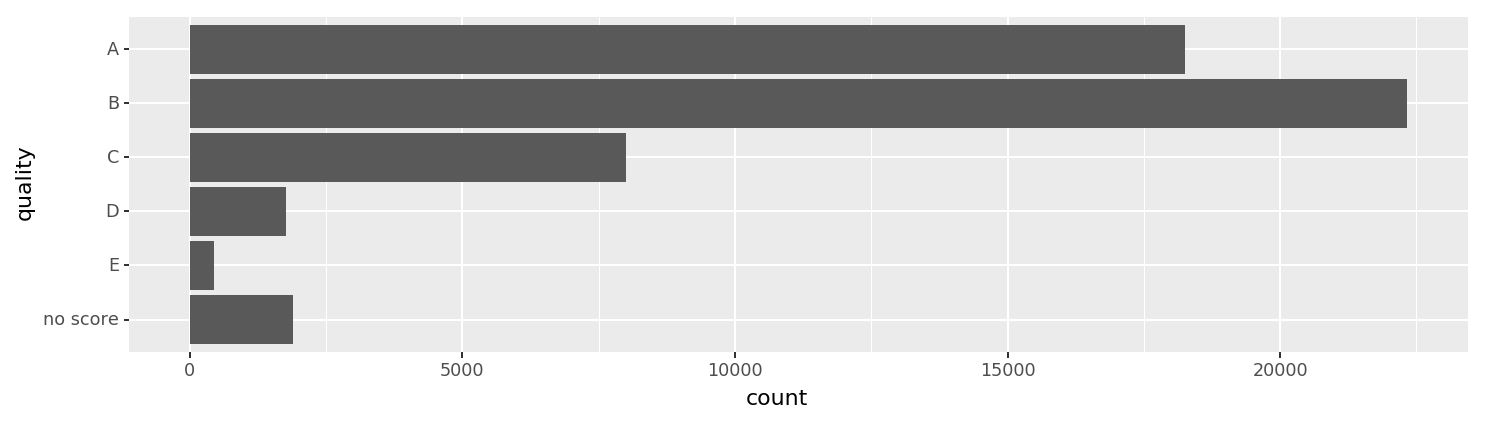

<ggplot: (-9223372036516394622)>

In [ ]:
(xc_meta
    .pipe(df_transform_cats, quality=reversed)
    .pipe(ggplot)
    + aes(x='quality')
    + geom_bar()
    + coord_flip()
    + theme_figsize(aspect=1/4)
)

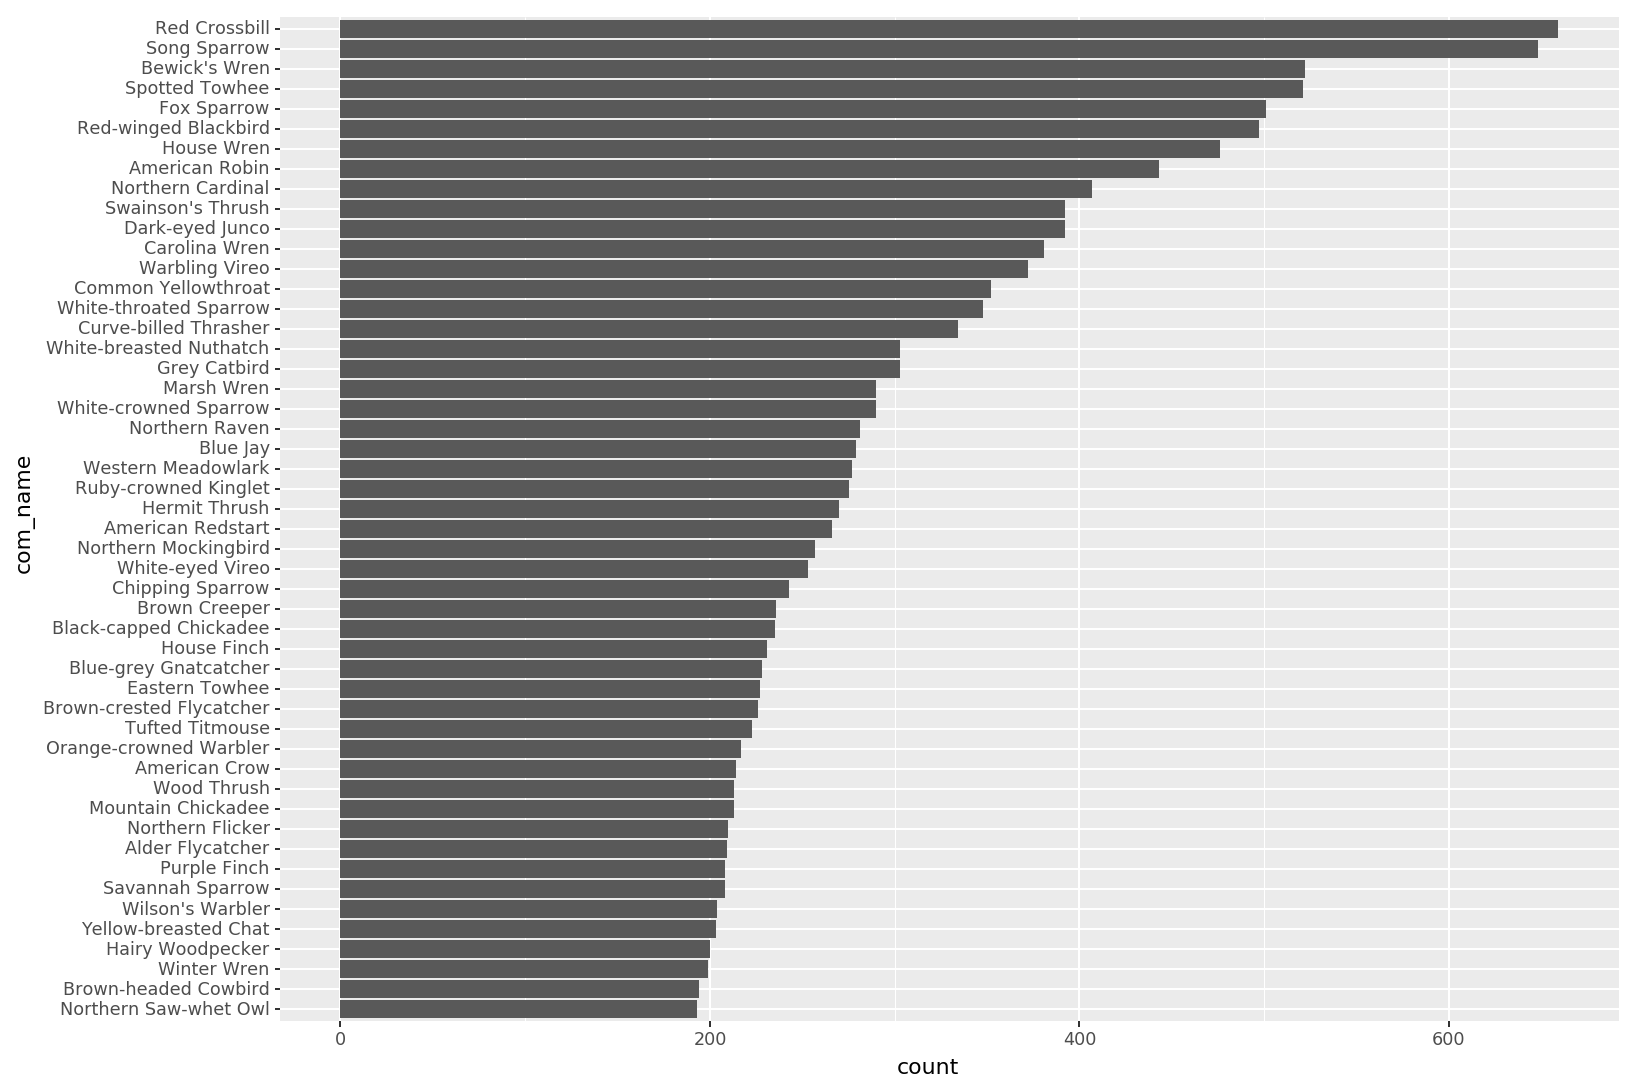

<ggplot: (-9223372036512439748)>

In [ ]:
(xc_meta
    [lambda df: df.com_name.isin(df.com_name.value_counts().index.tolist()[:50])]
    .pipe(df_ordered_cats_like, com_name=lambda s: s.value_counts().index.tolist())
    .pipe(df_transform_cats, com_name=reversed)
    .pipe(ggplot)
    + aes(x='com_name')
    + geom_bar()
    + coord_flip()
    + theme_figsize(aspect=3/4)
)

# Compute xc_p_sp
- One row per species in xc recs
- Computed from xc_meta, which is one row per xc rec

In [ ]:
xc_p_sp = (xc_meta

    # Count recs per sp
    .assign(n=1).groupby('shorthand')['n'].sum().reset_index()

    # Tidy
    .rename(columns={'shorthand': 'species'})
    .sort_values(['n'], ascending=[False])

    .pipe(df_inspect, lambda df: df[:10])
)

species    n
758    RECR  659
678    SOSP  648
513    BEWR  522
686    SPTO  521
667    FOSP  501
721    RWBL  497
507    HOWR  476
554    AMRO  443
696    NOCA  407
668    DEJU  392

# Compute ebird_p_sp
- One row per "non-noisy" species in ebird checklists
- Computed from bq ebird.obs_*, which are one row per (checklist, species)

In [ ]:
# Params
date_bin_weeks = (
    52  # 52w = 1 bin = don't separate by date
    # 13
)
table = (
    # 'ebird.obs_sample_001'     # XXX Dev
    'ebird.obs_all_expensive'  # WARNING
)
smooth_scale = (
    1  # 1x = no smoothing
)
hll_precision = (
    # https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#hyperloglog-functions
    # 10  # time:smooth[TODO] time:exact[TODO] -- XXX Dev
    # 15  # time:smooth[TODO] time:exact[17s] -- Some small errors vs. exact (for BGGN)
    # 18  # time:smooth[764s] time:exact[18s] -- No visible error vs. exact exact (for BGGN)
    24  # time:smooth[518s] time:exact[17s] -- Max precision, doesn't blow up mem and no slower than the others, so let's go with it
)

In [ ]:
# Base data
a = (bqq
    .query(
        from_=f"{table} e left join metadata.species s on (s.com_name = e.common_name)",
        where=f'''true
            and category in ('species', 'issf', 'form', 'intergrade')
            and country_code = 'US'
            # and state_code = 'US-CA'            # XXX Dev
            # and county_code = 'US-CA-075'       # XXX Dev (SF) -- XXX Not a good geo filter, very noisy!
            # and longitude between -122.6 and -122.3 and latitude between 37.66 and 37.82 # XXX Dev (SF)
        ''',
        # group_by='1,2,3', # For checklist_id
        group_by='1,2',   # For subbin_hll_checklists
        select=f'''
            {mul_trunc(ebird_week('observation_date'), date_bin_weeks)}               as date_bin,
            ifnull(s.shorthand, '_UNK')                                               as species,
            # sampling_event_identifier                                                 as checklist_id,
            hll_count.init(sampling_event_identifier, {hll_precision})                as subbin_hll_checklists,
        ''',
    )
    .inspect(lambda t: t.limit(10).df())
)

INFO     [15:45:19.452] [15496] 354 potoo.bqq/_bqq: Running query...

INFO     [15:45:20.805] [15496] 369 potoo.bqq/_bqq: [1s] cost[cached] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_X_7-b-3JHOBaZ30TBUOqTGMUF_95&page=queryresults]

INFO     [15:45:20.821] [15496] 385 potoo.bqq/_bqq: Fetching results...

INFO     [15:45:21.553] [15496] 419 potoo.bqq/_bqq: [1s]

date_bin species  \
0         0    GRAK   
1         0    NAPA   
2         0    HWAM   
3         0    NESH   
4         0    RAZO   
5         0    BBWO   
6         0    STGR   
7         0    WESP   
8         0    FEPE   
9         0    HPAT   

                                                                                                                                                                                     subbin_hll_checklists  
0  CHAQuMkBGAIgC4IH5d8DEKjJARgYIBky2d8DhQe0FYgNRIwMpAS0Gtob/AOMG4IG7geMLN4I8gKmKOQk+i3aTcgq5iLcB/YLhDfAH5IB0CLGGpIFnAOWAsIgrhnKBPAu7mSkGbROzAHgBvQLfNYC4GH+E4os7gymA9wDqiGABu4F0APMCagzqAHsHcog+iHQBcgC...  
1  CHAQ08cBGAIgC4IH69wDEMfHARgYIBky39wD+yv0VagN/iHIEqQE9gvqGtoQgAfUOogI0gUasgOQA7gNyhCiA+QKkB62HZwXthKeM+Yx4gqQNJ4X6gPgEMphmAHGJZgKogSmA5YV9gvSTfZcoAXMAtYTliLsD+YGiBaUEdgekD6MBLYvgg7IQYwf+gjQGMAdlgLs...  
2  CHAQ+CIYAiALggfsXBD4IhgYIBky4lyXEsIzwjLgwALMvwHmSK6rAoYBgGqk3AGcZNocpqwBks4CuooCrAHGqAGStAG0BfR53DDmhgGUE8wnhAmSW9RV6kr0NfwFvFegrwHuIYY4yknydMgc7FvyCZoI0ocBnOoClH7YrAGkK+oqnt8BjEyGX9aRAbZnonvwHsYf...  
3  CHAQ6gQYAiALggfNDxDqBBgYIBkyww/XYua8Bsz5A5LdAYx+5qAC2M8MuLEC0qEEnIgFlPUFoogLkMIBgpcF9vMFxlqEhwj+/QiSoBSgfIahBO7FBqb3A+aYAeQC+soDwuwGmu8M1LsUugesbNreA86UC86xD7oPzosEuLsC7LkEjKYK0MMJqsMBuNsB3NIQypgB...  
4  CHAQzJsCGAIgC4IHi5gFELqbAhgYIBky/5cF/Qm8EJgEnAFGigLuFeABgg8kqhOWEP4F9BjEBdgD8AuQAvgD1AfOBNIBtAfUHvQQ6CSMDGzsC44LtgTqAawC0gnQEoYDjgXcAYQFqAuWFLoD/gzgKLAK/grqCe4TwAXCBLgSlg6ED+oCqAqsGfALRMYJrgEs6hmM...  
5  CHAQuHsYAiALggfcrAIQtXsYGCAZMtGsAqcVnC7iCZoCgg6MDbwBkAvkENAD9hS+IrYh8kjaLdodliHcEvwSlmauiQG0BaY0sAKmG8o+mBaqBeoBigt0+g3+RIAHuAhuApwgsDOAD6YGviT8nQHsM5AJngzoR/Qa2hqACKAB1AfsPfIJgA/8duRMjjqcCN4Mvh7E...  
6  CHAQoXsYAiALggeWrQIQnHsYGCAZMoutArsbphzCA4YP/BGAI85GhgOiCrwU1gu8DvRSrBbeOowGlh6mTcIS+A+IG/xM9hziEKYPlAraA+Yv3CHCFapWkAG4NO4BwAzCE+YImgPCSDTYAaQH4BD8IaID1gHWJeAX3F/0IfpepBSIEvoH6mmCEZxC4jyIAdYHkkDg...  
7  CHAQxgcYAiALggeRFxC5BxgYIBkyhxe7nwKKNrKmFfTGFuigBZTRCrDKA7jaCPrqArzlDsY/4rgC9hq+uAHingL2oA2umwOARLzlBaquAdT5A8yvAZ6IAp61AdwBkmy6lgbokAL68wWwvgPu+wHYer6RC5LdA8DhB8zUA4DXA5qKA76TBMRjtC6QOY6cAcLxBMr+...  
8  CHAQugMYAiALgge6CxC6AxgYIBkysAu72wTurRHmngTgiAaSG7rREti7Cby0Cfhdhq4O8KcDiqAY1Kcp8LoEyPscltYWtusDlMwBlv4I6J0DnK0PnnKC5wvUwAqMkBDM6wvkrAW8kgzQvQHygCGAtQHm2w+i3QTMrRmA6gL6M/aUDPjfA8TmA/SLEd7OEsaQAcyT...  
9                                                                                                                                         CHAQBxgCIAuCByQQBxgYIBkyHLGXmwHW7/sB/phmuPrmB4TcheUEwdaQar+h2RI=

In [ ]:
# Aggregate across expanded geo
#   - Smooth if requested
#   - Using group-by-and-join i/o a single windowed query b/c the latter failed on resources and the former doesn't
#   - And hll_count.merge isn't supported in analytic queries (ugh), so we have to group-by-and-join to use that
c = (bqq
    .with_(
        a_or_b=a,  # (Not smoothing)
        c1=(bqq
            .query(
                from_='a_or_b',
                group_by='1,2',
                select=f'''
                    date_bin,
                    species,
                    # {smooth_scale} * count(distinct checklist_id) as bin_n_checklists_with_sp,
                    {smooth_scale} * hll_count.merge(subbin_hll_checklists) as bin_n_checklists_with_sp,
                ''',
            )
        ),
        c2=(bqq
            .query(
                from_='a_or_b',
                group_by='1',
                select=f'''
                    date_bin,
                    # {smooth_scale} * count(distinct checklist_id) as bin_n_checklists,
                    {smooth_scale} * hll_count.merge(subbin_hll_checklists) as bin_n_checklists,
                ''',
            )
        ),
    )
    .query(
        from_=f'''
            c1 join c2 using (
                date_bin
            )
        ''',
        select=f'''
            c1.*,
            c2.bin_n_checklists,
        ''',
    )
    .inspect(lambda t: t.limit(10).df())
)

INFO     [15:45:22.127] [15496] 354 potoo.bqq/_bqq: Running query...

INFO     [15:45:23.710] [15496] 369 potoo.bqq/_bqq: [2s] cost[cached] rows[10] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_9IZdwgGfqjbfo3RAUO5HrzJPZiNm&page=queryresults]

INFO     [15:45:23.725] [15496] 385 potoo.bqq/_bqq: Fetching results...

INFO     [15:45:23.974] [15496] 419 potoo.bqq/_bqq: [0s]

date_bin species  bin_n_checklists_with_sp  bin_n_checklists
0         0    HPAT                         7          26405592
1         0    RSMA                         9          26405592
2         0    GRWA                     26060          26405592
3         0    YEGR                        93          26405592
4         0    HAAK                      1622          26405592
5         0    STGU                       460          26405592
6         0    WCAL                        20          26405592
7         0    BLNO                      3560          26405592
8         0    RCWA                      2751          26405592
9         0    YNAL                        72          26405592

In [ ]:
# Query and compute bin_p_sp
ebird_p_sp = (c
    # .limit(50)  # XXX Dev
    .df(max_rows=None)  # i/o default max_rows=1000

    # Add bin_p_sp cols
    .assign(
        bin_p_sp_bar_width = lambda df: (df.bin_n_checklists_with_sp / df.bin_n_checklists).map(ebird_bar_width),
        bin_p_sp           = lambda df: df.bin_n_checklists_with_sp / df.bin_n_checklists,
    )

    # Filter out "noisy" species
    [lambda df: df.bin_p_sp_bar_width > 1]

    # Add category for species
    .pipe(df_ordered_cats_like, species=metadata.ebird.df.shorthand)
    .pipe(df_remove_unused_categories)

    # Sort
    .sort_values(['date_bin', 'bin_p_sp'], ascending=[True, False])

    # Inspect
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:15])
    .pipe(df_inspect, lambda df: df[-15:])
)

INFO     [17:58:48.815] [15496] 354 potoo.bqq/_bqq: Running query...

INFO     [17:58:50.732] [15496] 369 potoo.bqq/_bqq: [2s] cost[cached] rows[1397] size[0 B] url[https://console.cloud.google.com/bigquery?project=bubo-1&j=bq:US:job_S5fYqSHIsmdHXoHMB8DQ8GxVShAZ&page=queryresults]

INFO     [17:58:50.744] [15496] 385 potoo.bqq/_bqq: Fetching results...

INFO     [17:58:51.330] [15496] 419 potoo.bqq/_bqq: [1s]

(400, 6)

date_bin species  bin_n_checklists_with_sp  bin_n_checklists  bin_p_sp_bar_width  bin_p_sp
1354         0    MODO                   7732258          26405592                   6     0.293
1379         0    AMRO                   7412308          26405592                   6     0.281
1395         0    AMCR                   7309645          26405592                   6     0.277
984          0    NOCA                   7229124          26405592                   6     0.274
1183         0    BLJA                   6027767          26405592                   6     0.228
38           0    RWBL                   5712697          26405592                   6     0.216
361          0    EUST                   5672189          26405592                   6     0.215
979          0    SOSP                   5603383          26405592                   6     0.212
764          0    MALL                   5420886          26405592                   6     0.205
1166         0    CANG                   5403406          26405592                   6     0.205
520          0    AMGO                   5324999          26405592                   6     0.202
781          0    DOWO                   4931239          26405592                   5     0.187
190          0    HOFI                   4896628          26405592                   5     0.185
1157         0    TUVU                   4536200          26405592                   5     0.172
737          0    RBWO                   4319292          26405592                   5     0.164

date_bin species  bin_n_checklists_with_sp  bin_n_checklists  bin_p_sp_bar_width  bin_p_sp
957          0    GCTH                     89817          26405592                   2     0.003
927          0    NSHR                     89236          26405592                   2     0.003
453          0    BAGO                     88502          26405592                   2     0.003
6            0    LALO                     88354          26405592                   2     0.003
1257         0    BTGN                     88116          26405592                   2     0.003
1089         0    ROGO                     88038          26405592                   2     0.003
21           0    GREJ                     86881          26405592                   2     0.003
901          0    REKN                     86588          26405592                   2     0.003
1079         0    SNOW                     86486          26405592                   2     0.003
966          0    RNSA                     84146          26405592                   2     0.003
101          0    COHU                     83138          26405592                   2     0.003
676          0    CAVI                     82987          26405592                   2     0.003
945          0    BUOW                     81999          26405592                   2     0.003
487          0    WRSA                     81804          26405592                   2     0.003
1277         0    BBIH                     81764          26405592                   2     0.003

# Compare xc counts vs. ebird counts
- (Will want to use ebird p_sp as baseline)

In [ ]:
xc_vs_ebird = (ebird_p_sp
    .pipe(df_inspect, lambda df: (df.shape,))

    .merge(how='left', on='species', right=(xc_p_sp
        .rename(columns={'n': 'xc_n_recs'})
    ))
    .merge(how='left', on='species', right=(metadata.ebird.df
        .rename(columns={'shorthand': 'species'})
        [['species', 'com_name', 'species_group', 'family', 'order']]
    ))

    .pipe(df_inspect, '\nDropping nulls from xc_meta:')
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: (df
        [lambda df: df.xc_n_recs.isnull()]
        .pipe(df_inspect, lambda df: (df.shape,))
    ))
    [lambda df: ~df.xc_n_recs.isnull()]

    .pipe(df_inspect, '\nDropping nulls from metadata.ebird.df:')
    .pipe(df_inspect, lambda df: (df
        .pipe(df_inspect, lambda df: (df.shape,))
        [lambda df: df.order.isnull()]
        .pipe(df_inspect, lambda df: (df.shape,))
    ))
    [lambda df: ~df.order.isnull()]

    # Restore category on .species
    .pipe(df_ordered_cats_like, species=ebird_p_sp.species)
    .pipe(df_remove_unused_categories)
    .sort_values('species')

    .pipe(df_inspect, '\nResult:')
    .pipe(df_inspect, lambda df: (df.shape,))
    .pipe(df_inspect, lambda df: df[:10])
)

(400, 6)


Dropping nulls from xc_meta:

(400, 11)

(7, 11)

date_bin species  bin_n_checklists_with_sp  bin_n_checklists  bin_p_sp_bar_width  bin_p_sp  xc_n_recs             com_name  \
46          0    HERG                   1927801          26405592                   4     0.073        NaN         Herring Gull   
271         0    WWSC                    220090          26405592                   2     0.008        NaN  White-winged Scoter   
324         0    NOGA                    154442          26405592                   2     0.006        NaN      Northern Gannet   
371         0    SATE                    102988          26405592                   2     0.004        NaN        Sandwich Tern   
375         0    ICGU                     98878          26405592                   2     0.004        NaN         Iceland Gull   
386         0    NSHR                     89236          26405592                   2     0.003        NaN      Northern Shrike   
393         0    SNOW                     86486          26405592                   2     0.003        NaN            Snowy Owl   

                          species_group                                  family            order  
46           Gulls, Terns, and Skimmers    Laridae (Gulls, Terns, and Skimmers)  Charadriiformes  
271                           Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)     Anseriformes  
324  Frigatebirds, Boobies, and Gannets           Sulidae (Boobies and Gannets)       Suliformes  
371          Gulls, Terns, and Skimmers    Laridae (Gulls, Terns, and Skimmers)  Charadriiformes  
375          Gulls, Terns, and Skimmers    Laridae (Gulls, Terns, and Skimmers)  Charadriiformes  
386                             Shrikes                      Laniidae (Shrikes)    Passeriformes  
393                                Owls                        Strigidae (Owls)     Strigiformes


Dropping nulls from metadata.ebird.df:

(393, 11)

(0, 11)

Empty DataFrame
Columns: [date_bin, species, bin_n_checklists_with_sp, bin_n_checklists, bin_p_sp_bar_width, bin_p_sp, xc_n_recs, com_name, species_group, family, order]
Index: []


Result:

(393, 11)

date_bin species  bin_n_checklists_with_sp  bin_n_checklists  bin_p_sp_bar_width  bin_p_sp  xc_n_recs                      com_name  \
267         0    BBWD                    225254          26405592                   2     0.009       44.0  Black-bellied Whistling-Duck   
211         0    SNGO                    349661          26405592                   3     0.013       65.0                    Snow Goose   
390         0    ROGO                     88038          26405592                   2     0.003        6.0                  Ross's Goose   
276         0    GWFG                    212515          26405592                   2     0.008       35.0   Greater White-fronted Goose   
254         0    BRAN                    248028          26405592                   2     0.009       26.0                         Brant   
260         0    CACG                    239510          26405592                   2     0.009       34.0                Cackling Goose   
9           0    CANG                   5403406          26405592                   6     0.205      116.0                  Canada Goose   
160         0    MUSW                    531622          26405592                   3     0.020        8.0                     Mute Swan   
308         0    TRUS                    179975          26405592                   2     0.007       44.0                Trumpeter Swan   
273         0    TUSW                    215105          26405592                   2     0.008       32.0                   Tundra Swan   

    species_group                                  family         order  
267     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
211     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
390     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
276     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
254     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
260     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
9       Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
160     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
308     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes  
273     Waterfowl  Anatidae (Ducks, Geese, and Waterfowl)  Anseriformes

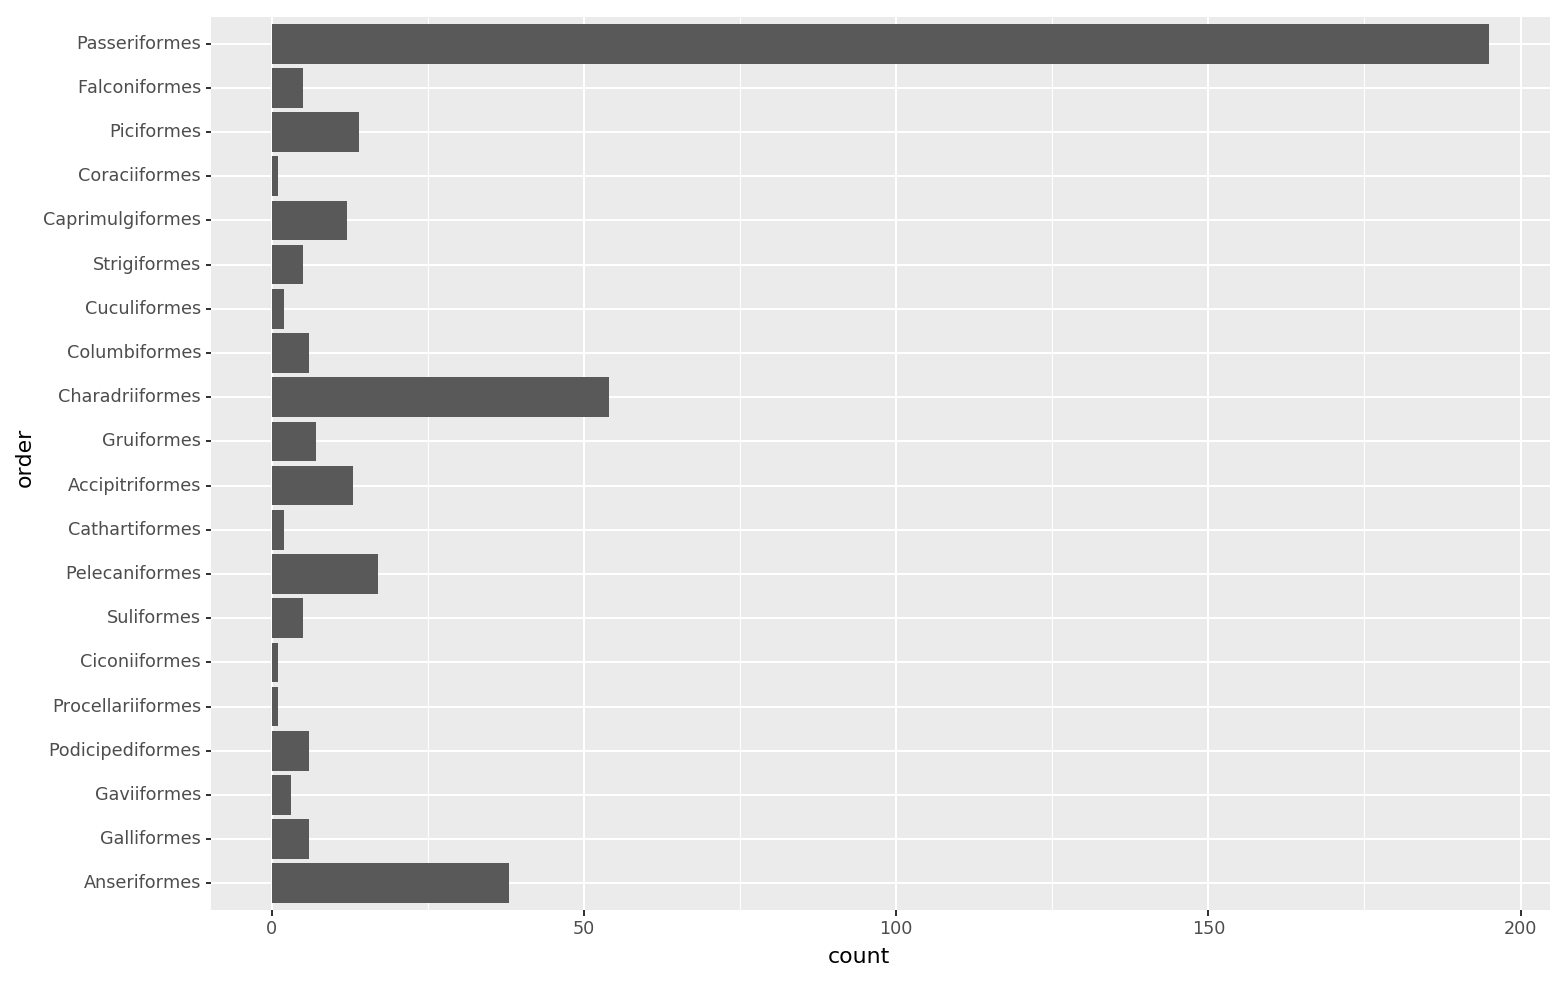

<ggplot: (359625406)>

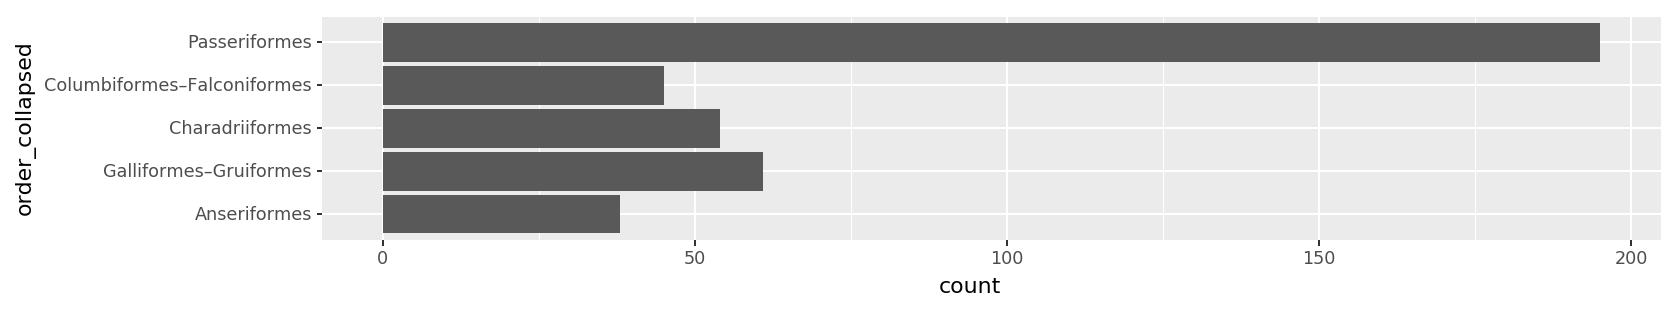

<ggplot: (358544381)>

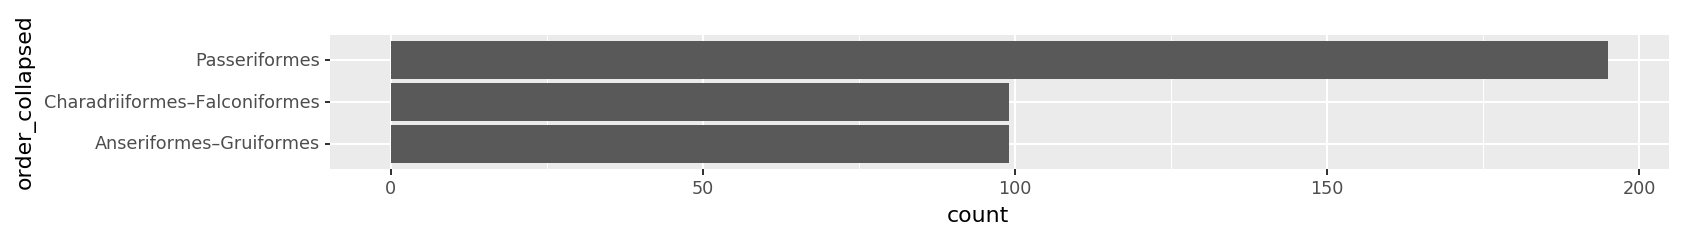

<ggplot: (399238720)>

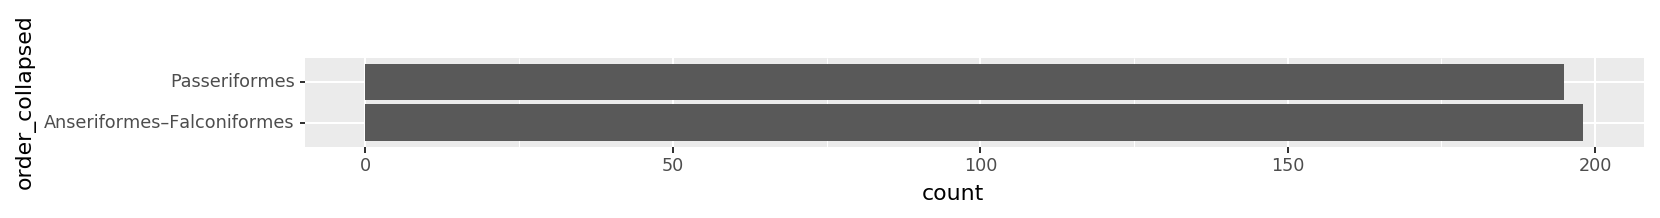

<ggplot: (357348279)>

In [ ]:
# Collapse order
#   - For <<20 facets

def order_collapsed_5(df) -> pd.Series:
    replace = {
        'Anseriformes':      'Anseriformes',
        'Galliformes':       'Galliformes–Gruiformes',
        'Gaviiformes':       'Galliformes–Gruiformes',
        'Podicipediformes':  'Galliformes–Gruiformes',
        'Procellariiformes': 'Galliformes–Gruiformes',
        'Ciconiiformes':     'Galliformes–Gruiformes',
        'Suliformes':        'Galliformes–Gruiformes',
        'Pelecaniformes':    'Galliformes–Gruiformes',
        'Cathartiformes':    'Galliformes–Gruiformes',
        'Accipitriformes':   'Galliformes–Gruiformes',
        'Gruiformes':        'Galliformes–Gruiformes',
        'Charadriiformes':   'Charadriiformes',
        'Columbiformes':     'Columbiformes–Falconiformes',
        'Cuculiformes':      'Columbiformes–Falconiformes',
        'Strigiformes':      'Columbiformes–Falconiformes',
        'Caprimulgiformes':  'Columbiformes–Falconiformes',
        'Coraciiformes':     'Columbiformes–Falconiformes',
        'Piciformes':        'Columbiformes–Falconiformes',
        'Falconiformes':     'Columbiformes–Falconiformes',
        'Passeriformes':     'Passeriformes',
    }
    return (df
        .order
        .replace(replace)
        .pipe(as_ordered_cat_like, replace.values())
    )

def order_collapsed_3(df) -> pd.Series:
    replace = {
        'Anseriformes':      'Anseriformes–Gruiformes',
        'Galliformes':       'Anseriformes–Gruiformes',
        'Gaviiformes':       'Anseriformes–Gruiformes',
        'Podicipediformes':  'Anseriformes–Gruiformes',
        'Procellariiformes': 'Anseriformes–Gruiformes',
        'Ciconiiformes':     'Anseriformes–Gruiformes',
        'Suliformes':        'Anseriformes–Gruiformes',
        'Pelecaniformes':    'Anseriformes–Gruiformes',
        'Cathartiformes':    'Anseriformes–Gruiformes',
        'Accipitriformes':   'Anseriformes–Gruiformes',
        'Gruiformes':        'Anseriformes–Gruiformes',
        'Charadriiformes':   'Charadriiformes–Falconiformes',
        'Columbiformes':     'Charadriiformes–Falconiformes',
        'Cuculiformes':      'Charadriiformes–Falconiformes',
        'Strigiformes':      'Charadriiformes–Falconiformes',
        'Caprimulgiformes':  'Charadriiformes–Falconiformes',
        'Coraciiformes':     'Charadriiformes–Falconiformes',
        'Piciformes':        'Charadriiformes–Falconiformes',
        'Falconiformes':     'Charadriiformes–Falconiformes',
        'Passeriformes':     'Passeriformes',
    }
    return (df
        .order
        .replace(replace)
        .pipe(as_ordered_cat_like, replace.values())
    )

def order_collapsed_2(df) -> pd.Series:
    replace = {
        'Anseriformes':      'Anseriformes–Falconiformes',
        'Galliformes':       'Anseriformes–Falconiformes',
        'Gaviiformes':       'Anseriformes–Falconiformes',
        'Podicipediformes':  'Anseriformes–Falconiformes',
        'Procellariiformes': 'Anseriformes–Falconiformes',
        'Ciconiiformes':     'Anseriformes–Falconiformes',
        'Suliformes':        'Anseriformes–Falconiformes',
        'Pelecaniformes':    'Anseriformes–Falconiformes',
        'Cathartiformes':    'Anseriformes–Falconiformes',
        'Accipitriformes':   'Anseriformes–Falconiformes',
        'Gruiformes':        'Anseriformes–Falconiformes',
        'Charadriiformes':   'Anseriformes–Falconiformes',
        'Columbiformes':     'Anseriformes–Falconiformes',
        'Cuculiformes':      'Anseriformes–Falconiformes',
        'Strigiformes':      'Anseriformes–Falconiformes',
        'Caprimulgiformes':  'Anseriformes–Falconiformes',
        'Coraciiformes':     'Anseriformes–Falconiformes',
        'Piciformes':        'Anseriformes–Falconiformes',
        'Falconiformes':     'Anseriformes–Falconiformes',
        'Passeriformes':     'Passeriformes',
    }
    return (df
        .order
        .replace(replace)
        .pipe(as_ordered_cat_like, replace.values())
    )

display(
    (xc_vs_ebird
        .pipe(df_remove_unused_categories)
        .pipe(ggplot) + aes(x='order') + geom_bar() + coord_flip() + theme_figsize(aspect=20/30)
    ),
    (xc_vs_ebird
        .pipe(df_remove_unused_categories)
        .assign(order_collapsed=lambda df: df.pipe(order_collapsed_5))
        .pipe(ggplot) + aes(x='order_collapsed') + geom_bar() + coord_flip() + theme_figsize(aspect=5/30)
    ),
    (xc_vs_ebird
        .pipe(df_remove_unused_categories)
        .assign(order_collapsed=lambda df: df.pipe(order_collapsed_3))
        .pipe(ggplot) + aes(x='order_collapsed') + geom_bar() + coord_flip() + theme_figsize(aspect=3/30)
    ),
    (xc_vs_ebird
        .pipe(df_remove_unused_categories)
        .assign(order_collapsed=lambda df: df.pipe(order_collapsed_2))
        .pipe(ggplot) + aes(x='order_collapsed') + geom_bar() + coord_flip() + theme_figsize(aspect=2/30)
    ),
)

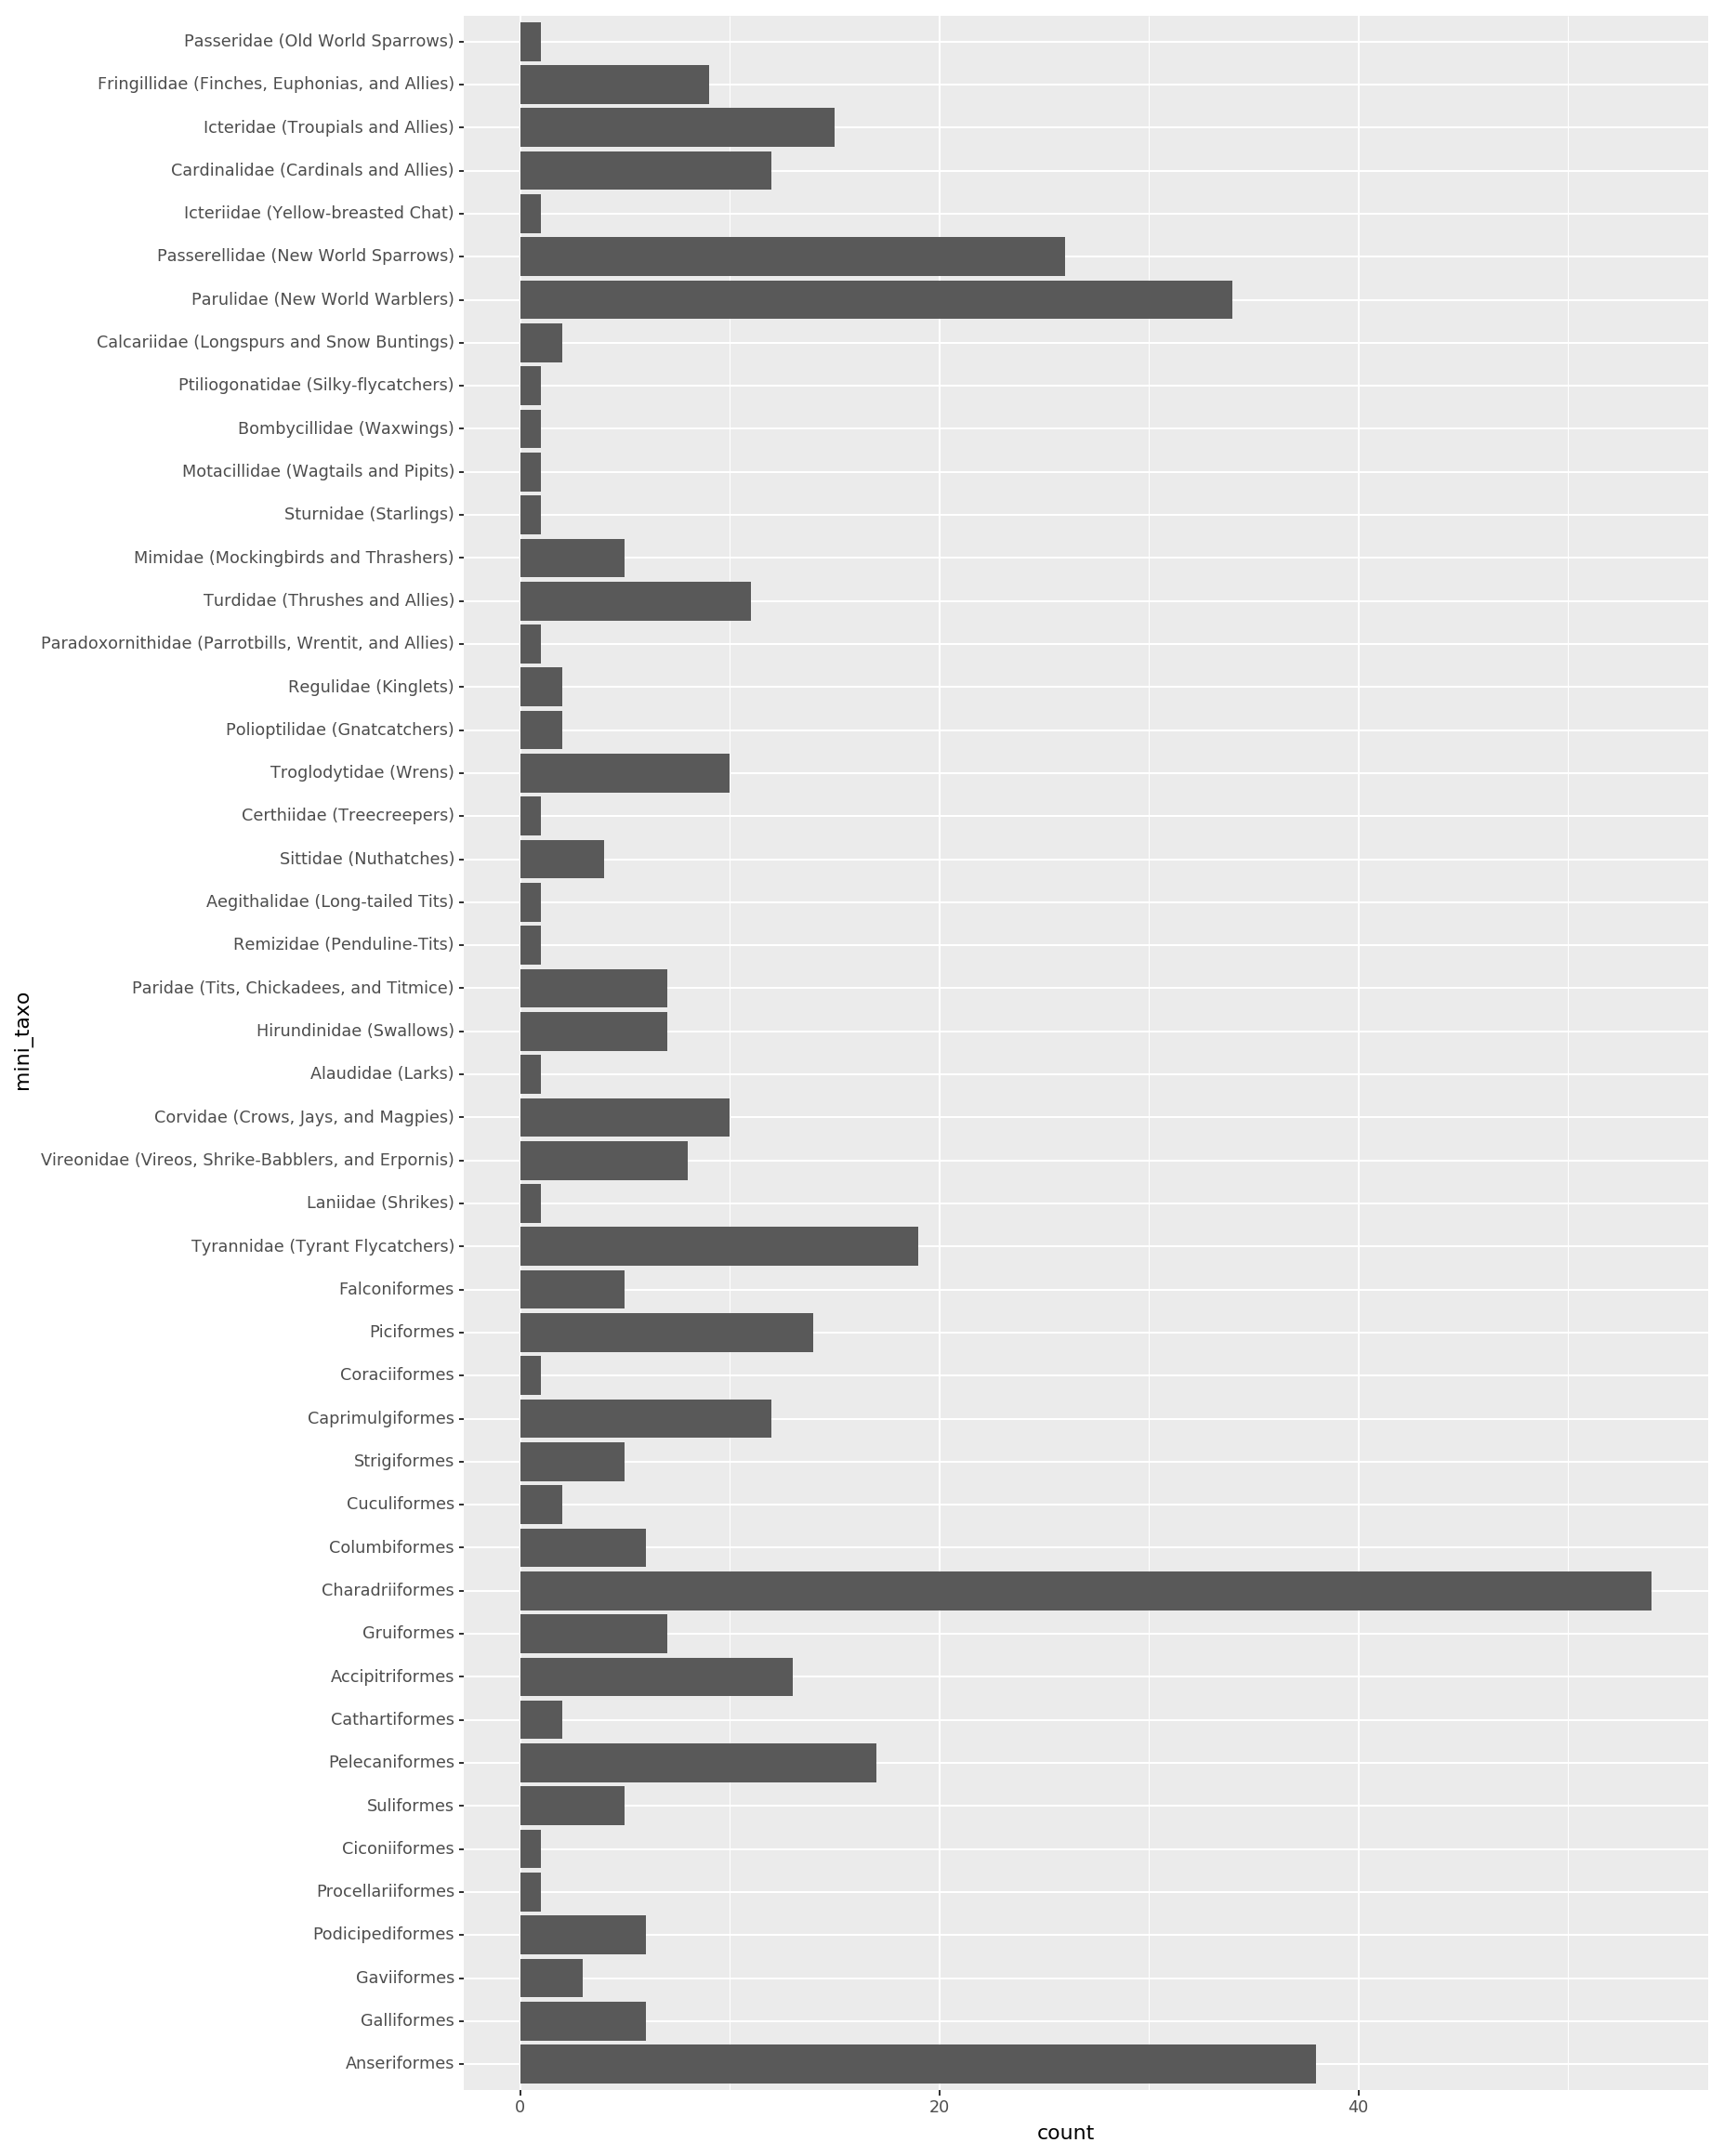

(<ggplot: (-9223372036495849861)>,)

In [ ]:
# mini_taxo
#   - For many small facets

def mini_taxo(df) -> pd.Series:
    return (df
        .pipe(df_map_rows, lambda row: (
            row.family if row.order == 'Passeriformes' else
            row.order
        ))
        .pipe(as_ordered_cat_like, [*df.order.cat.categories, *df.family.cat.categories])
        .cat.remove_unused_categories()
    )

(xc_vs_ebird
    .assign(mini_taxo=lambda df: df.pipe(mini_taxo))
    .pipe(ggplot) + aes(x='mini_taxo') + geom_bar() + coord_flip() + theme_figsize(aspect=50/30)
),

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/utils.py:633: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


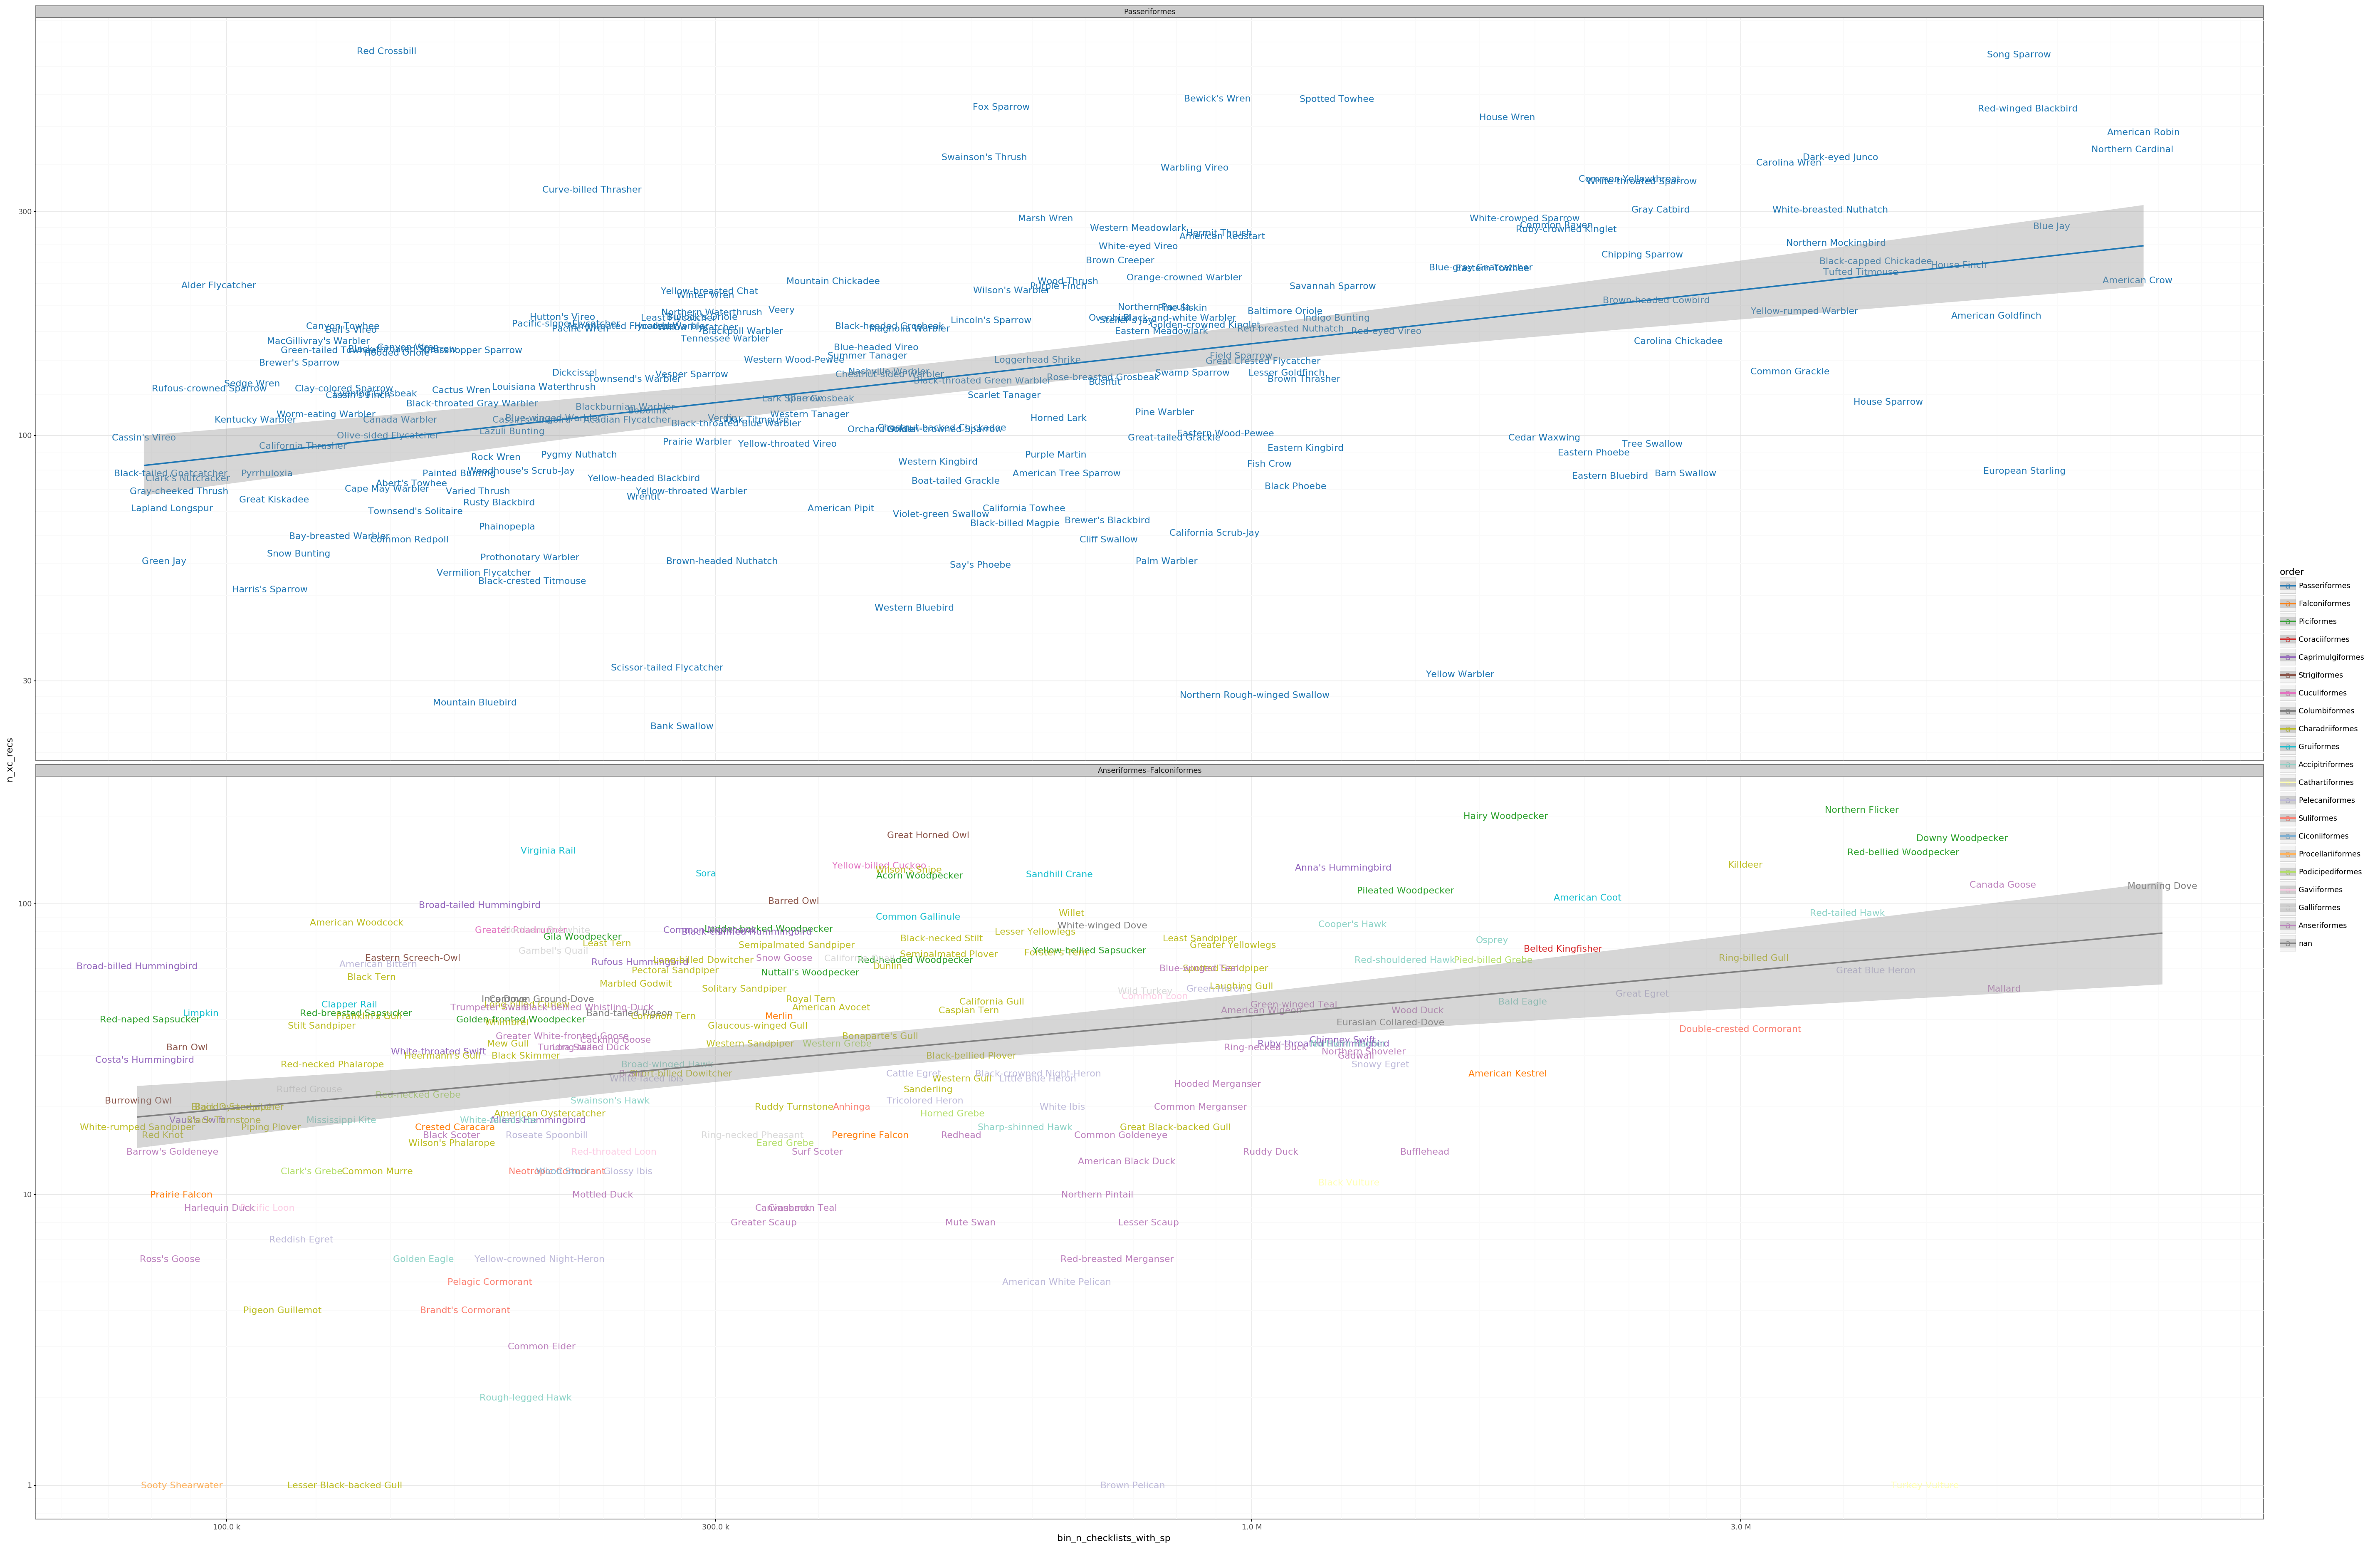

<ggplot: (356828238)>

In [ ]:
(xc_vs_ebird

    # Avoid many unused colors in the legend
    .pipe(df_remove_unused_categories)

    # More cols
    .assign(order_collapsed=lambda df: df.pipe(order_collapsed_2))

    # For easier color selection
    .pipe(df_reverse_cats, 'family', 'order', 'species_group', 'order_collapsed')

    .pipe(ggplot)

    + facet_wrap('order_collapsed',
        ncol=1,
        scales='free_y',
    )

    + aes(
        # x='bin_p_sp',
        x='bin_n_checklists_with_sp',
        y='xc_n_recs',
    )

    + aes(
        # color='family',  # 63 in US (too granular)
        # color='species_group',  # 53 in US (too granular)
        color='order',  # 20 in US
        # color='order_collapsed',
    )
    + scale_color_cmap_d(
        mpl_cmap_concat('tab10', 'Set3'),
        # 'viridis',
    )

    # + geom_label(
    + geom_text(
        # aes(label='species'),
        aes(label='com_name'),
        # position=position_dodge(width=10),
        # position=position_jitterdodge(),
    )

    + geom_smooth(
        method='lm',
        mapping=aes(group=0),  # [Can't lm outside of facet, would have to lm before plotting]
    )

    + scale_x_log10(labels=lambda breaks: [strip_endswith(humanize.naturalsize(x), 'B') for x in breaks])
    + scale_y_log10()

    + guides(color=guide_legend(ncol=1))
    + theme_bw()
    + theme_figsize(
        aspect=1/3,
        # aspect=1/2,
        # aspect=2/3,
        # aspect=1,
        # width=8,
        # width=12,
        # width=24,
        width=48,
    )

)

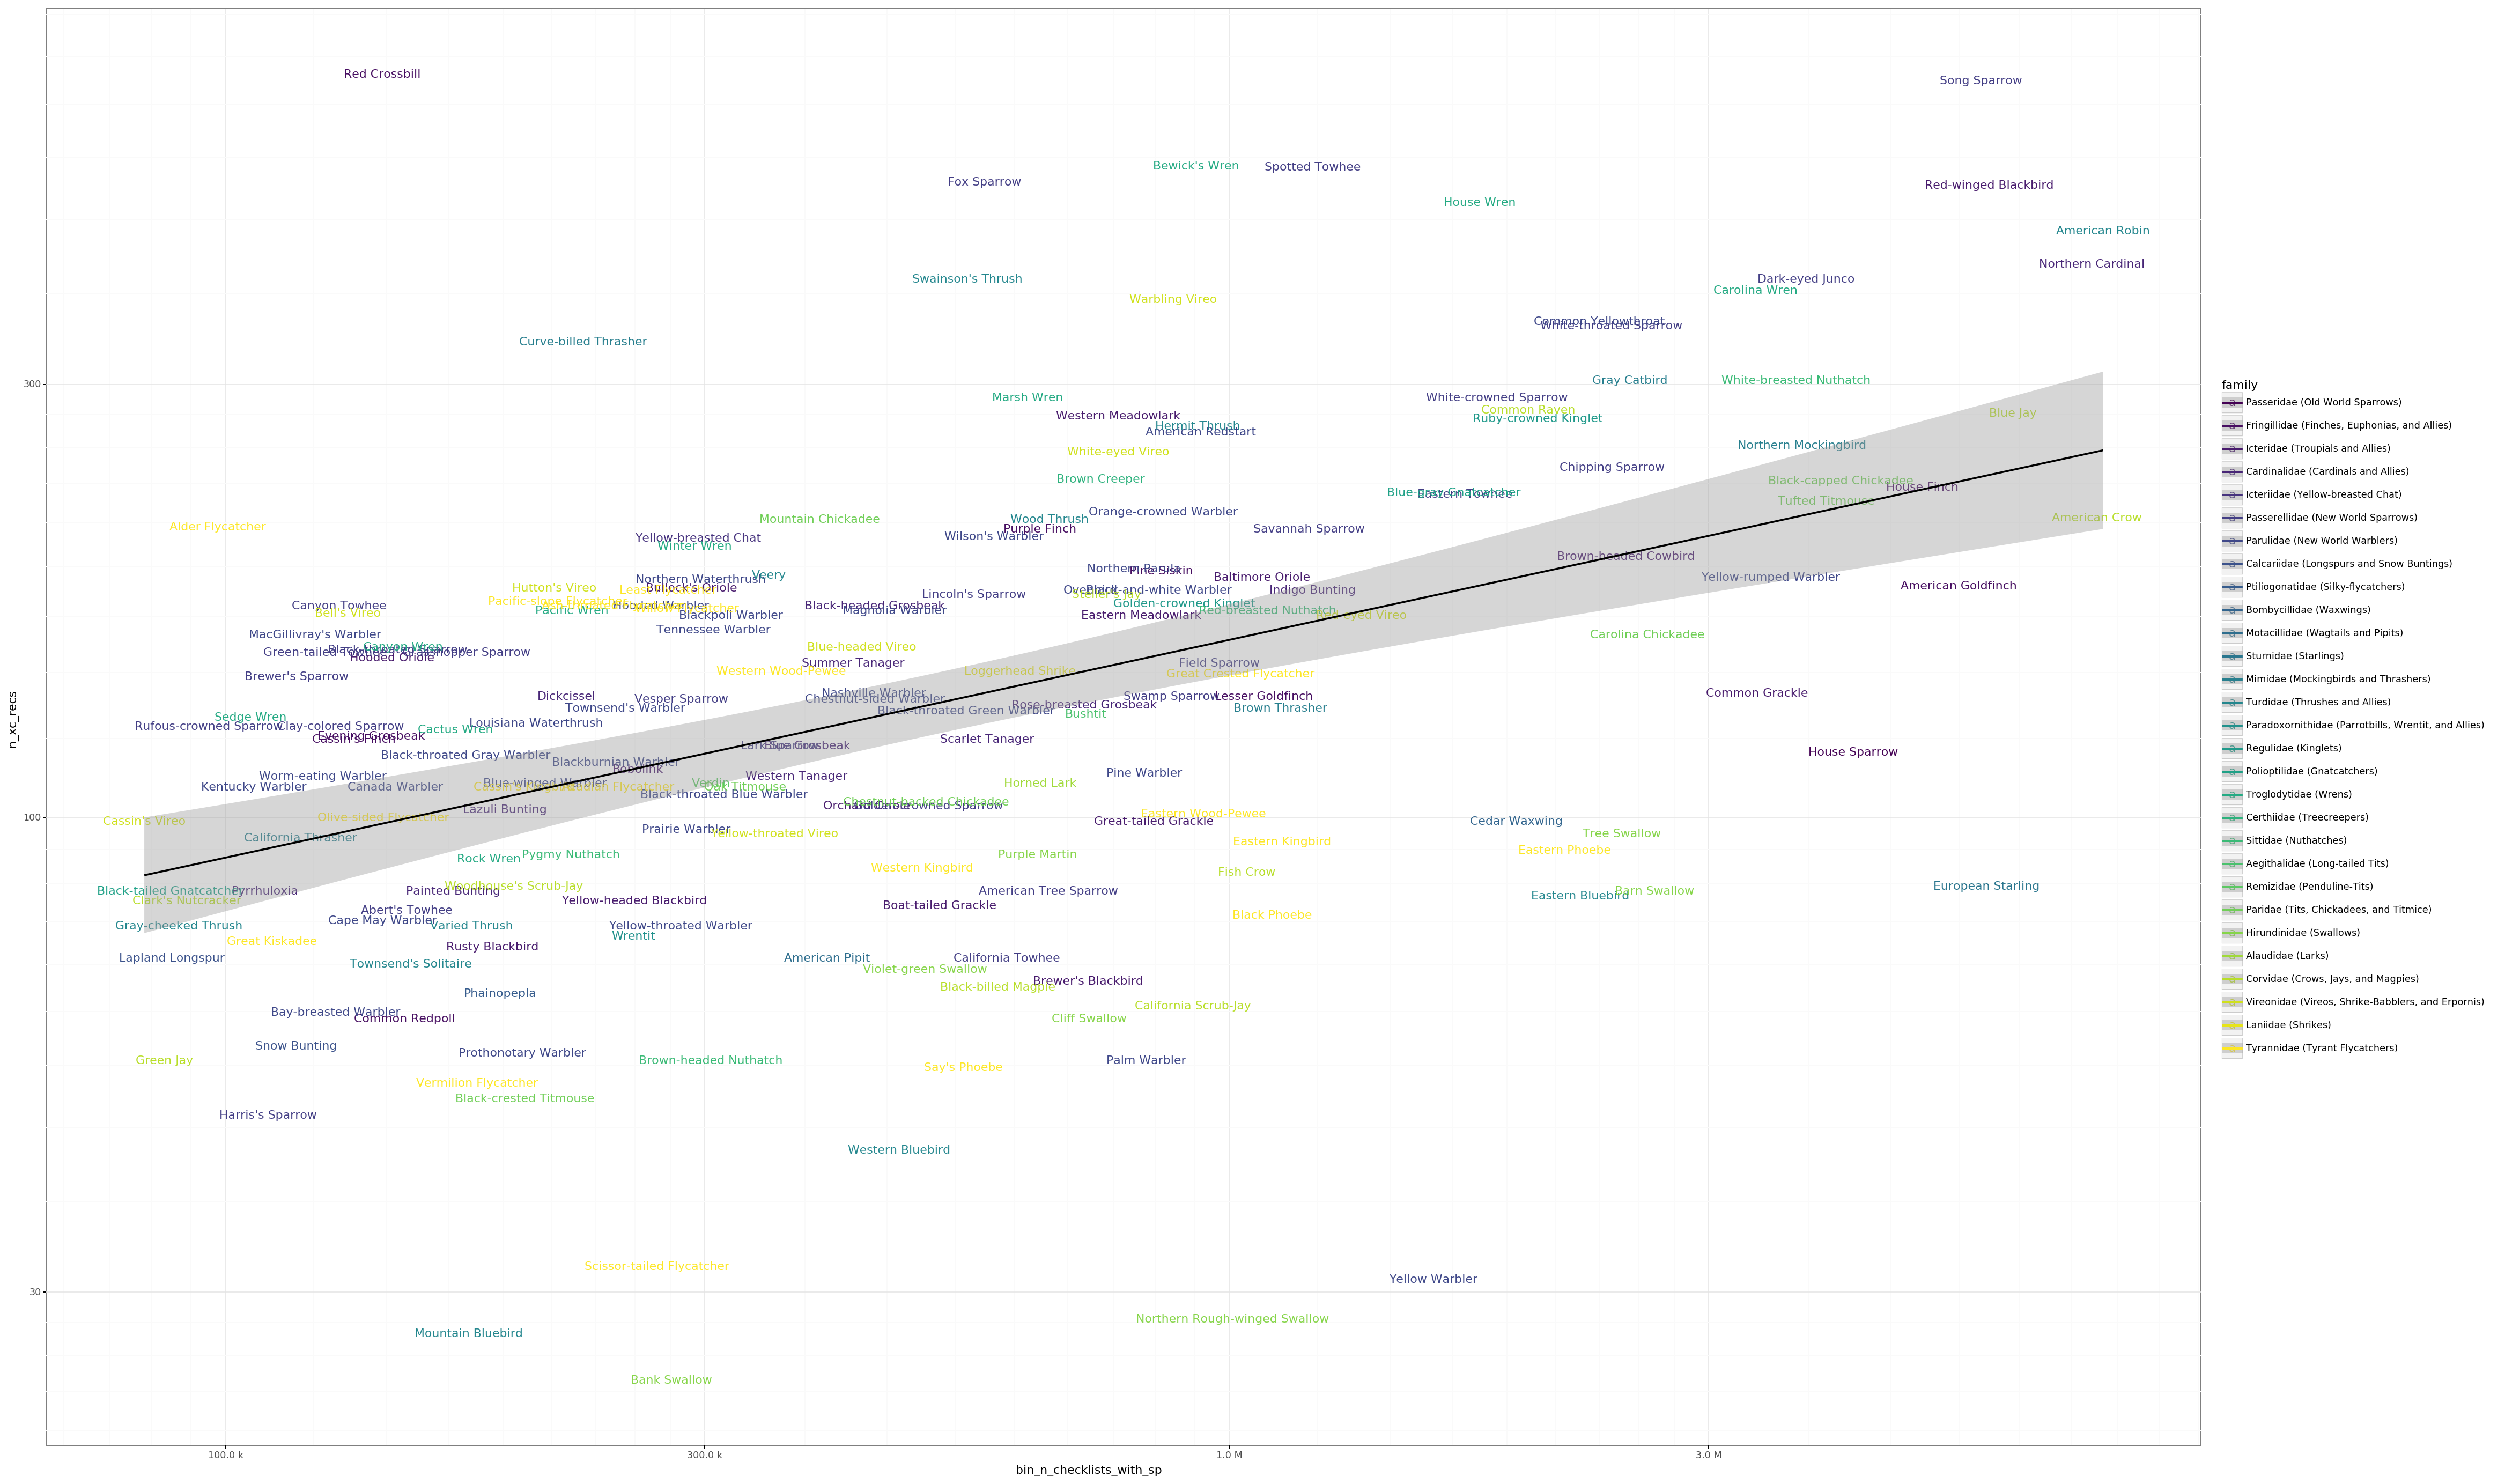

<ggplot: (-9223372036495242657)>

In [ ]:
# Passeriformes
(xc_vs_ebird

    # Filter to Passeriformes
    [lambda df: df.order.isin(['Passeriformes'])]

    # Avoid many unused colors in the legend
    .pipe(df_remove_unused_categories)

    # For easier color selection
    .pipe(df_reverse_cats, 'family', 'order', 'species_group')

    .pipe(ggplot)

    + aes(
        # x='bin_p_sp',
        x='bin_n_checklists_with_sp',
        y='xc_n_recs',
    )

    + aes(
        color='family',           # 63 in US / 29 in Passeriformes
        # color='species_group',  # 53 in US / ~26 in Passeriformes
        # color='order',          # 20 in US / 1 in Passeriformes
    )
    + scale_color_cmap_d(
        'viridis',
        # mpl_cmap_concat('tab10', 'Set3'),
    )

    # + geom_label(
    + geom_text(
        # aes(label='species'),
        aes(label='com_name'),
        # position=position_dodge(width=10),
        # position=position_jitterdodge(),
    )

    + geom_smooth(
        method='lm',
        mapping=aes(group=0),  # [Can't lm outside of facet, would have to lm before plotting]
    )

    + scale_x_log10(labels=lambda breaks: [strip_endswith(humanize.naturalsize(x), 'B') for x in breaks])
    + scale_y_log10()

    + guides(color=guide_legend(ncol=1))
    + theme_bw()
    + theme_figsize(
        # aspect=1/3,
        # aspect=1/2,
        aspect=2/3,
        # aspect=1,
        # width=8,
        # width=12,
        # width=24,
        width=36,
        # width=48,
    )

)

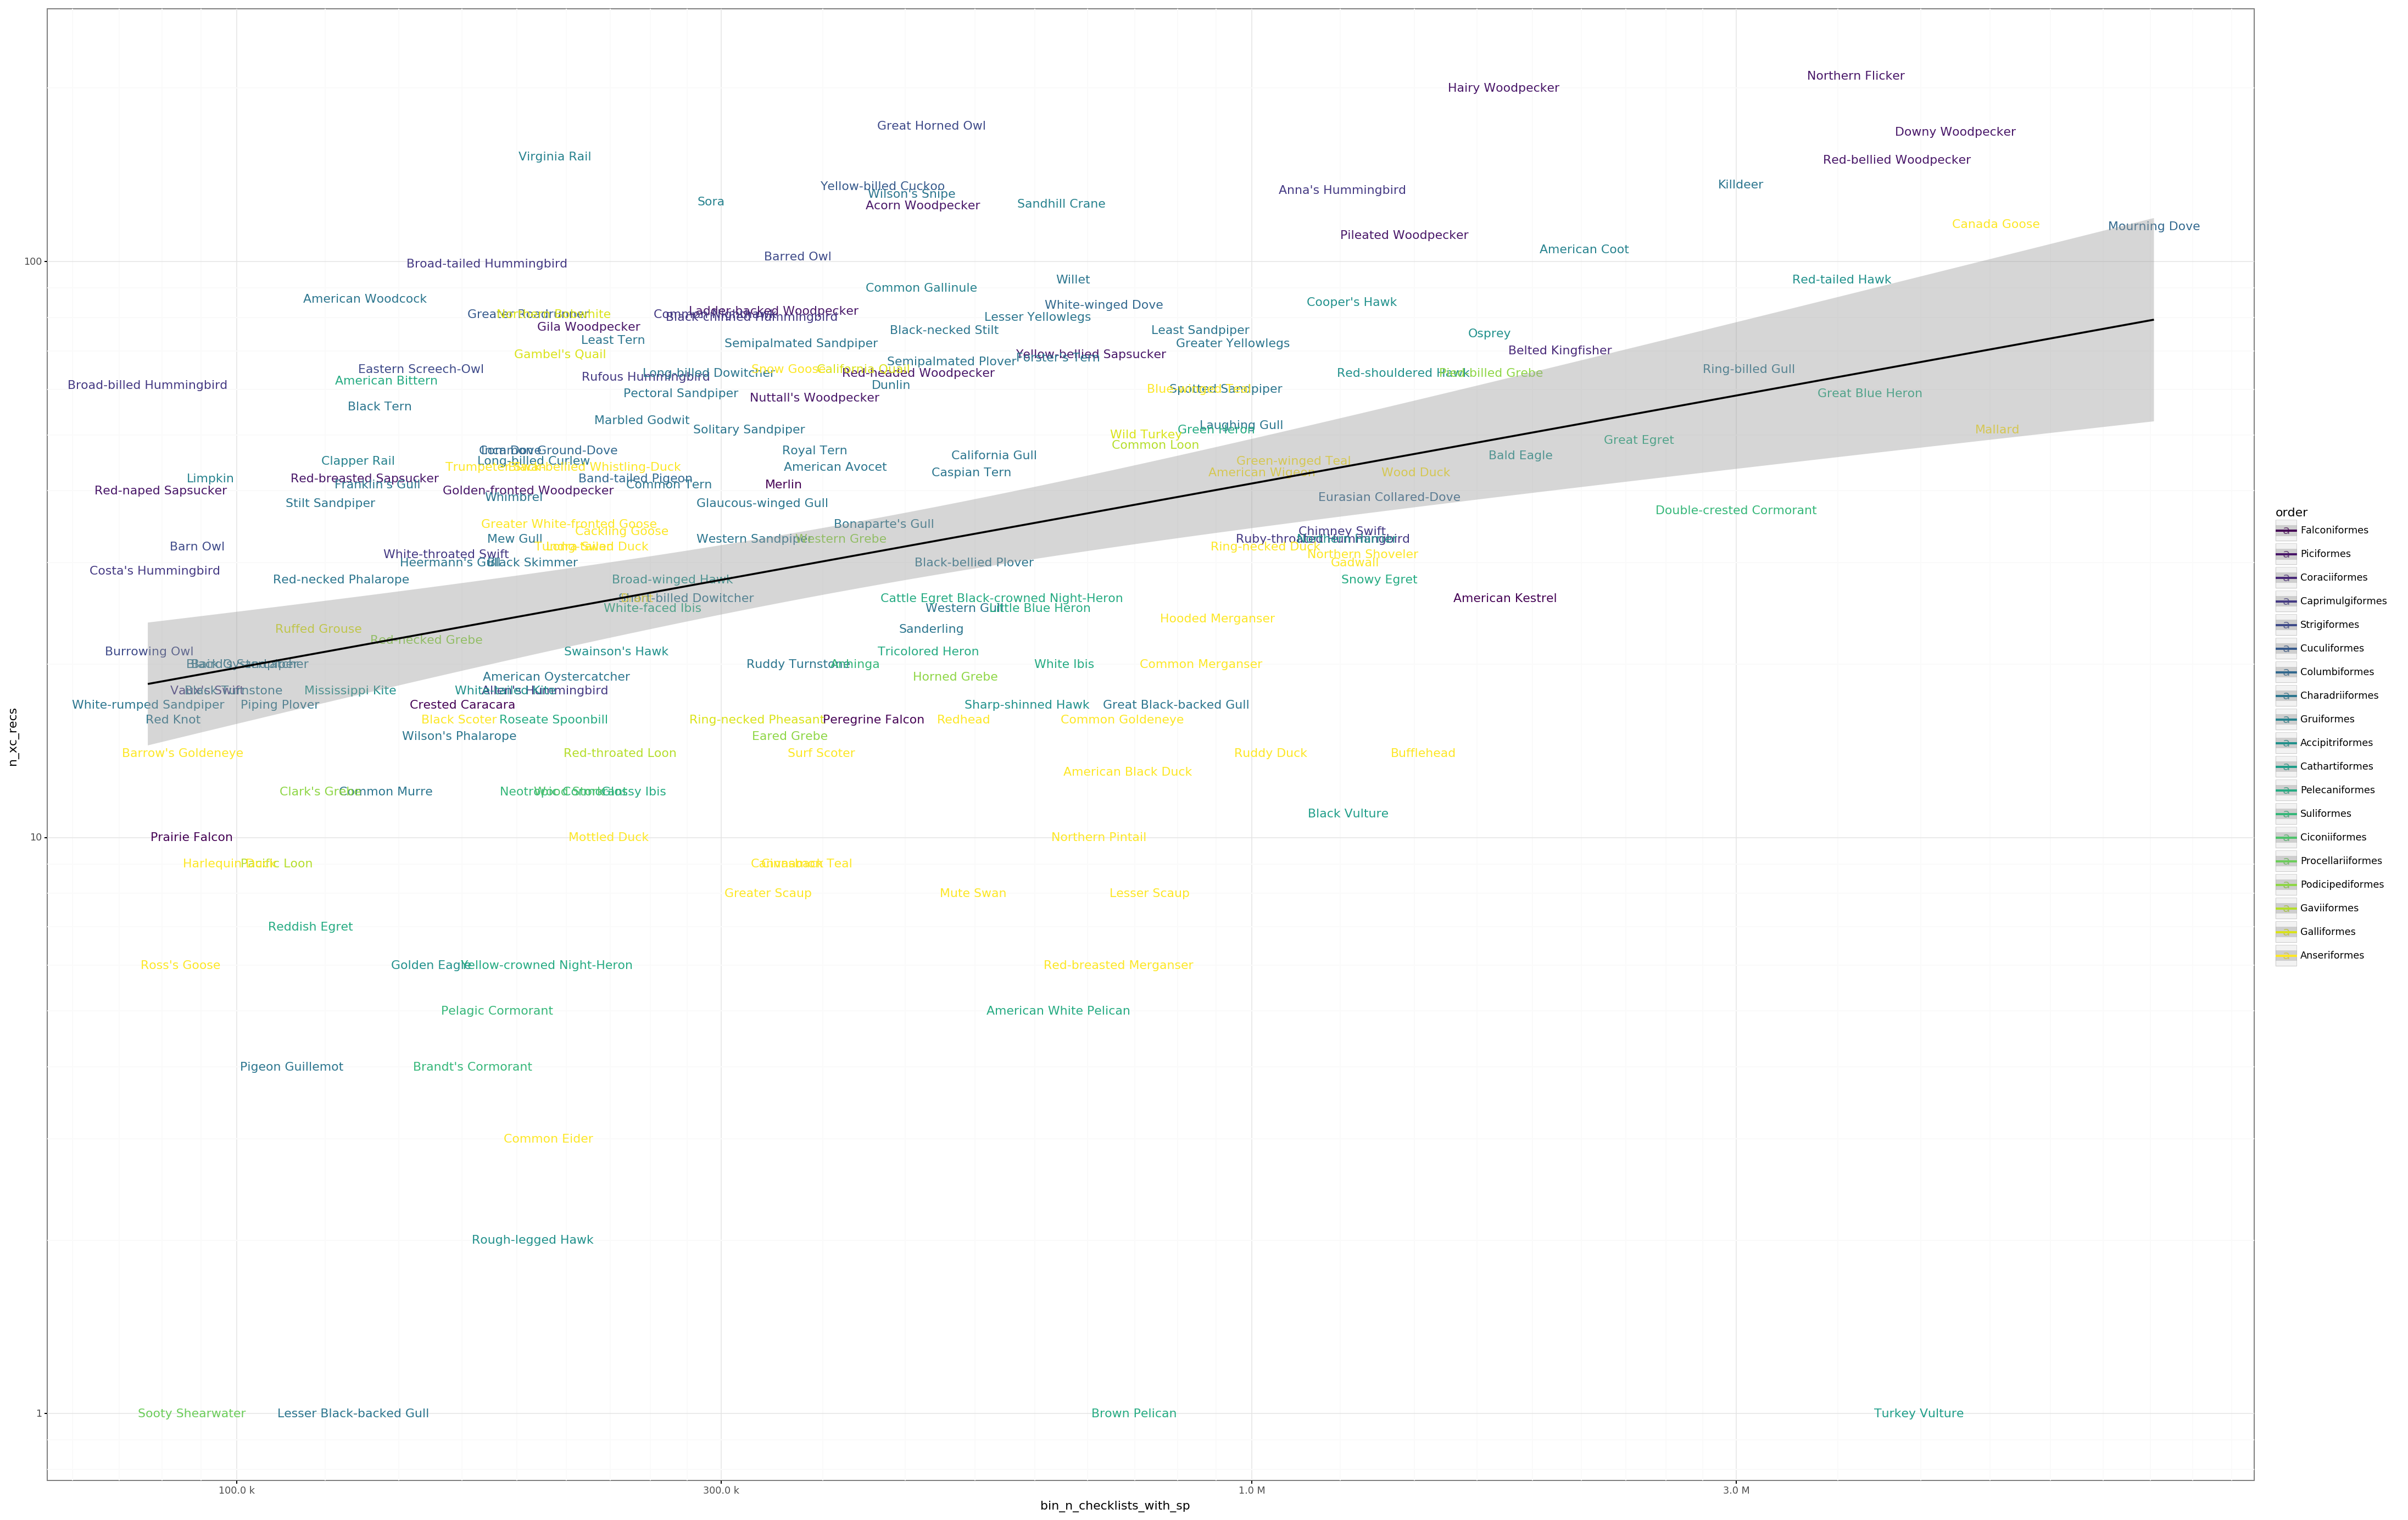

<ggplot: (-9223372036497161696)>

In [ ]:
# Not Passeriformes
(xc_vs_ebird

    # Filter to ~Passeriformes
    [lambda df: ~df.order.isin(['Passeriformes'])]

    # Avoid many unused colors in the legend
    .pipe(df_remove_unused_categories)

    # For easier color selection
    .pipe(df_reverse_cats, 'family', 'order', 'species_group')

    .pipe(ggplot)

    + aes(
        # x='bin_p_sp',
        x='bin_n_checklists_with_sp',
        y='xc_n_recs',
    )

    + aes(
        # color='family',         # 63 in US / 29 in Passeriformes
        # color='species_group',  # 53 in US / ~26 in Passeriformes
        color='order',            # 20 in US / 1 in Passeriformes
    )
    + scale_color_cmap_d(
        'viridis',
        # mpl_cmap_concat('tab10', 'Set3'),
    )

    # + geom_label(
    + geom_text(
        # aes(label='species'),
        aes(label='com_name'),
        # position=position_dodge(width=10),
        # position=position_jitterdodge(),
    )

    + geom_smooth(
        method='lm',
        mapping=aes(group=0),  # [Can't lm outside of facet, would have to lm before plotting]
    )

    + scale_x_log10(labels=lambda breaks: [strip_endswith(humanize.naturalsize(x), 'B') for x in breaks])
    + scale_y_log10()

    + guides(color=guide_legend(ncol=1))
    + theme_bw()
    + theme_figsize(
        # aspect=1/3,
        # aspect=1/2,
        aspect=2/3,
        # aspect=1,
        # width=8,
        # width=12,
        # width=24,
        width=36,
        # width=48,
    )

)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/utils.py:633: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


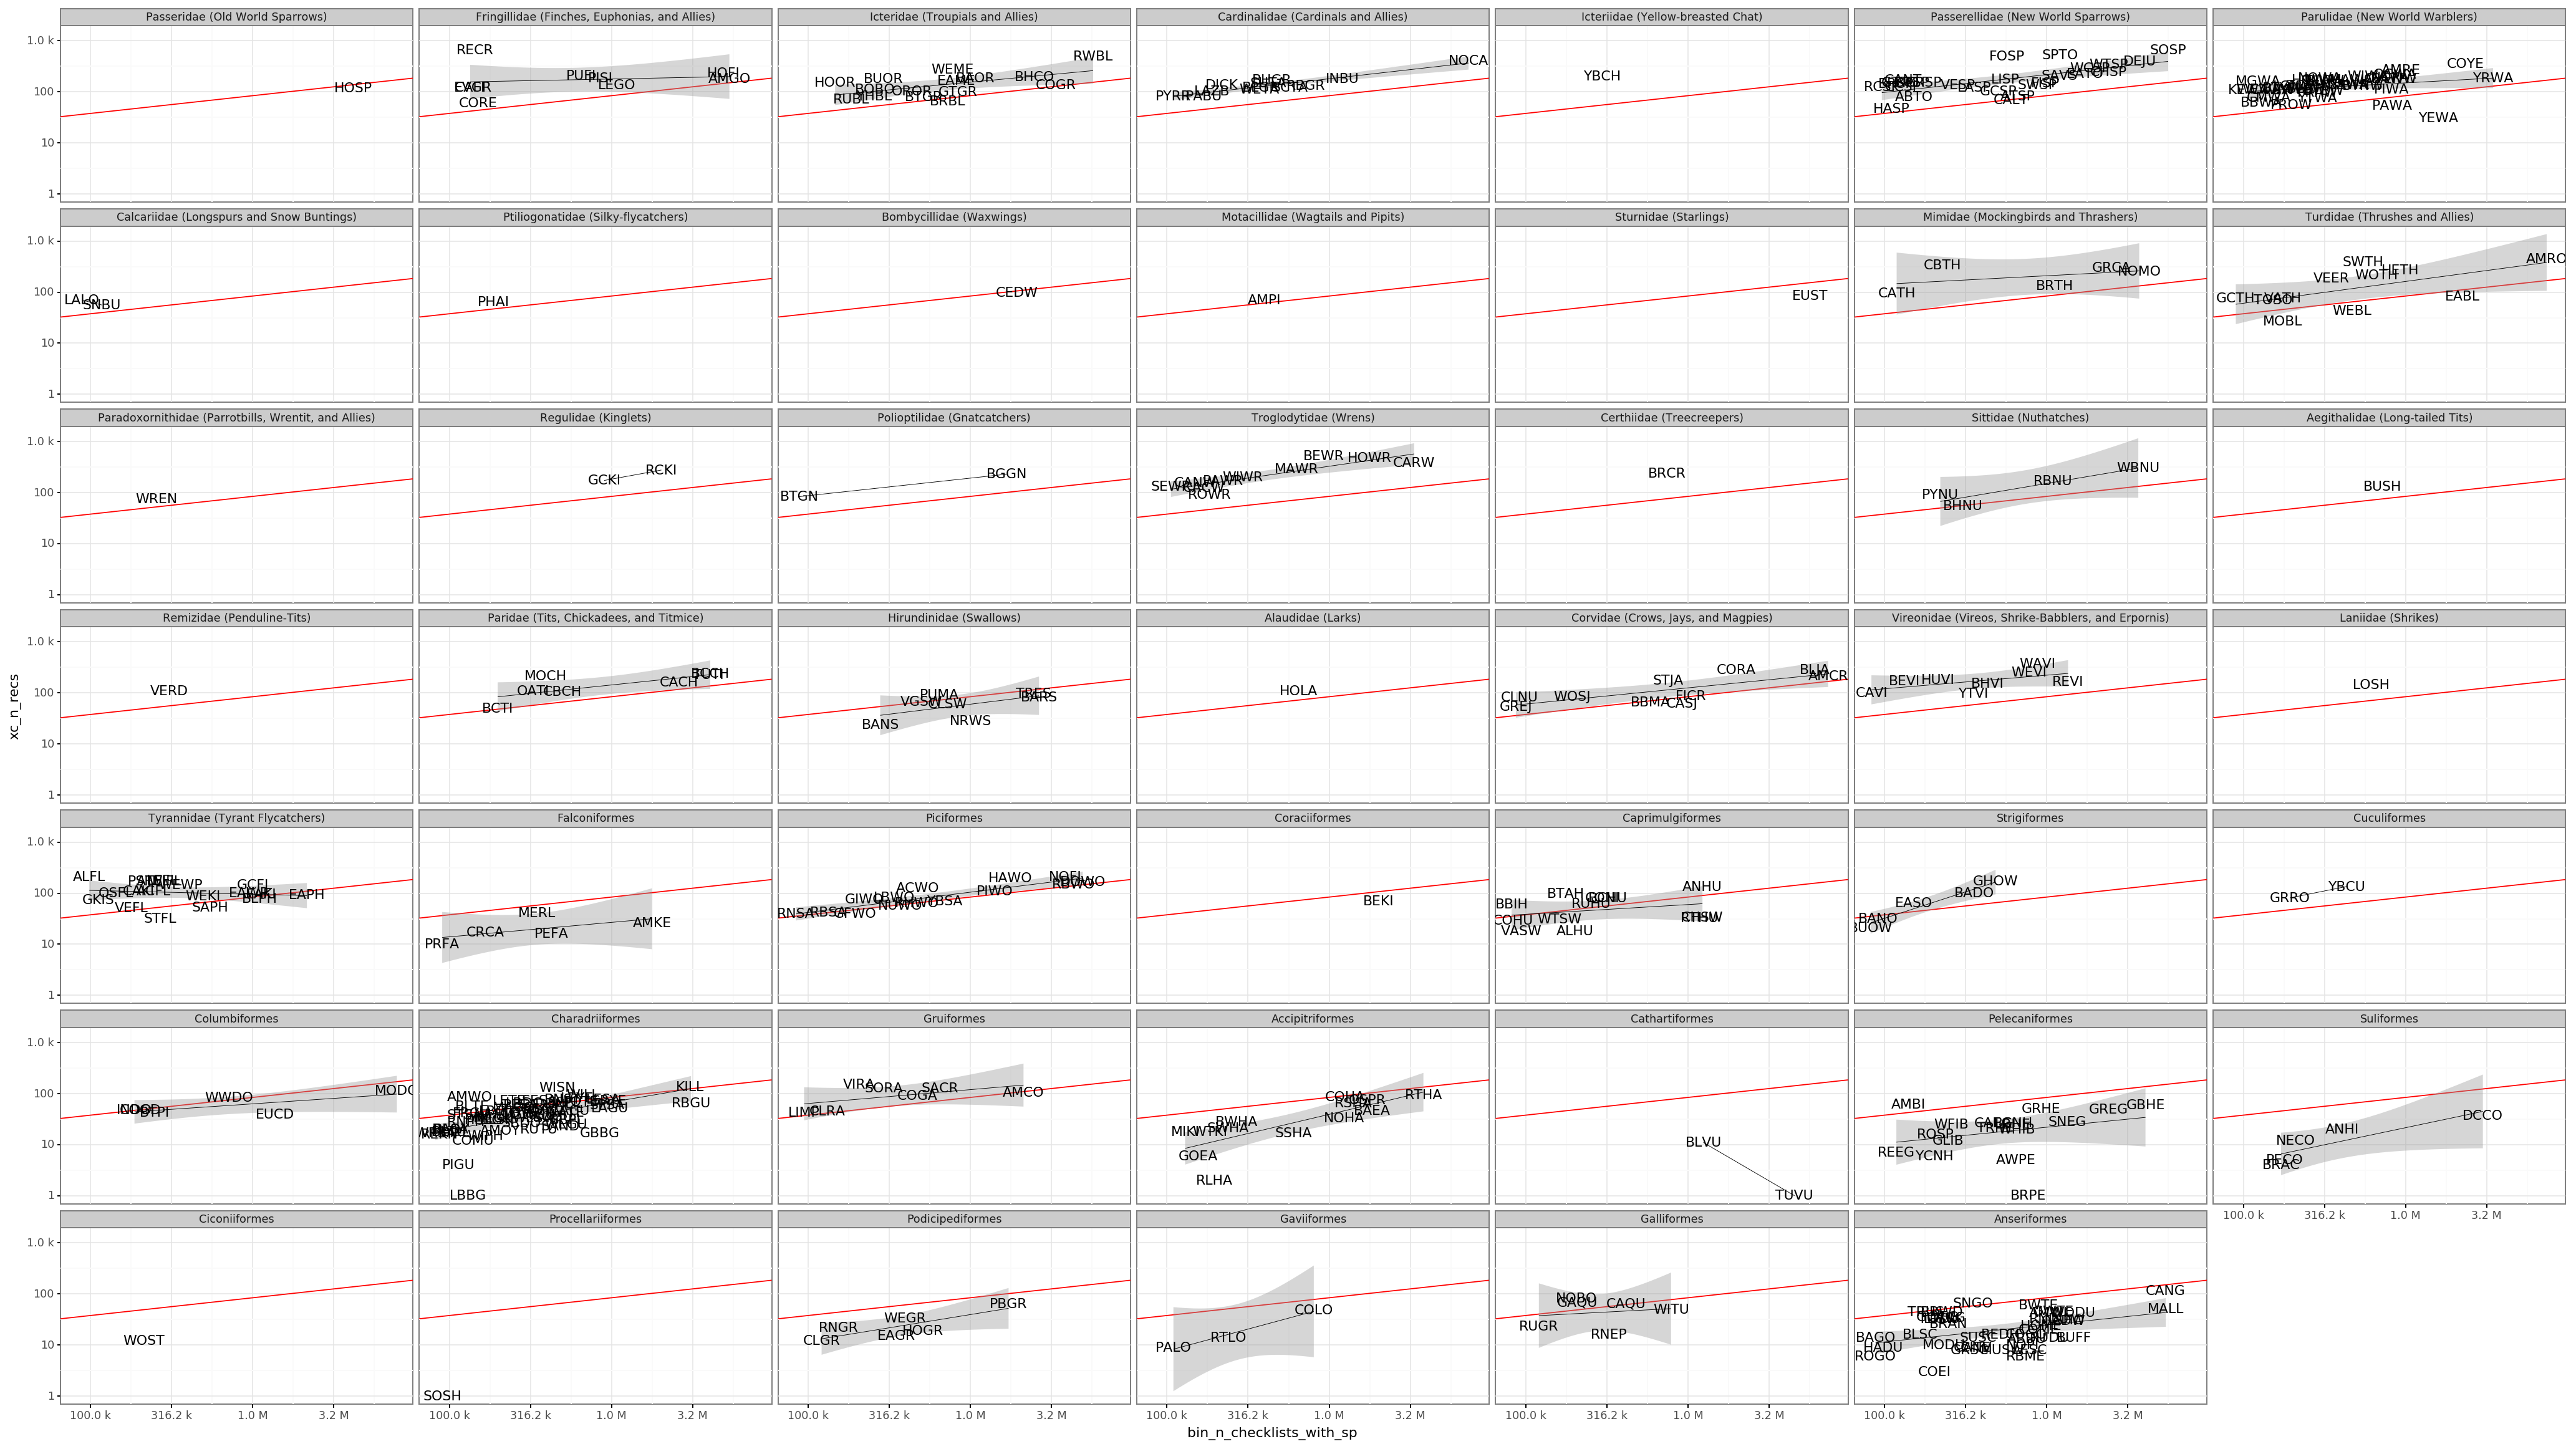

<ggplot: (368310960)>

In [ ]:
# Facet by mini_taxo
(xc_vs_ebird
    # [:20]  # XXX Dev
    # [-25:]  # XXX Dev

    # Avoid many unused colors in the legend
    .pipe(df_remove_unused_categories)

    # Add mini_taxo
    .assign(mini_taxo=lambda df: df.pipe(mini_taxo))

    # For easier color selection
    .pipe(df_reverse_cats, 'family', 'order', 'species_group', 'mini_taxo')

    # Manual log scale (so we can geom_abline)
    .assign(
        bin_n_checklists_with_sp = lambda df: df.bin_n_checklists_with_sp .pipe(np.log10),
        xc_n_recs                = lambda df: df.xc_n_recs                .pipe(np.log10),
    )

    .pipe(lambda df: df
        .pipe(ggplot)

        + facet_wrap('mini_taxo',
            # ncol=4,
        )

        # # Global regression line (across all facets)
        + geom_abline_for_lm(df, 'xc_n_recs ~ bin_n_checklists_with_sp',
            # color='#444444',
            color='red',
            # alpha=.5,
        )

        + aes(
            # x='bin_p_sp',
            x='bin_n_checklists_with_sp',
            y='xc_n_recs',
        )

        + geom_smooth(
            method='lm',
            size=.25,
            # alpha=.5,
        )

        + geom_text(
            aes(label='species'),
            # aes(label='com_name'),
        )

        # Manual log scale (so we can geom_abline)
        # + scale_x_log10(labels=lambda breaks: [strip_endswith(humanize.naturalsize(x), 'B') for x in breaks])
        # + scale_y_log10()
        + scale_x_continuous(labels=lambda xs: [naturalsize_no_suffix(np.power(10, x)) for x in xs])
        + scale_y_continuous(labels=lambda xs: [naturalsize_no_suffix(np.power(10, x)) for x in xs])

        + guides(color=guide_legend(ncol=1))
        + theme_bw()
        + theme_figsize(
            # aspect=1/3,
            aspect=1/2,
            # aspect=2/3,
            # aspect=1,
            # width=8,
            # width=12,
            # width=24,
            width=36,
            # width=48,
        )

    )
)

# TODO TODO Ready to write the paper!
- Center around the figure above
- See notebook for hand-written outline (with Alex)

# TODO Clean up
- Manually lump 'Magrove Warbler' + 'American Yellow Warbler' from xc (see section below)
- Filter ebird/xc to the same time window?
    - Too noisy on the xc side?

# FIXME Need to manually lump 'Magrove Warbler' + 'American Yellow Warbler' from xc
- https://birdsna.org/Species-Account/bna/species/yelwar
- https://en.wikipedia.org/wiki/American_yellow_warbler
- In xc
    - https://www.xeno-canto.org/species/Setophaga-aestiva -- American Yellow Warbler
    - https://www.xeno-canto.org/species/Setophaga-petechia -- Mangrove Warbler
    - Any others? (e.g. Golden Warbler)

In [ ]:
(metadata.ebird.df
    [lambda df: (df.shorthand == 'YEWA') | (df.com_name.isin(['Yellow Warbler', 'Mangrove Warbler']))]
)

shorthand               longhand            sci_name        com_name species_code taxon_order  taxon_id com_name_codes sci_name_codes  \
9222      YEWA  Yellow Warbler - YEWA  Setophaga petechia  Yellow Warbler       yelwar     27885.0  TC010505           AYWA           SEPE   

     banding_codes  species_group                          family          order  
9222          YEWA  Wood-Warblers  Parulidae (New World Warblers)  Passeriformes

In [ ]:
(xc_meta
    [lambda df: df.species.isin(['YEWA']) | df.com_name.isin(['Mangrove Warbler'])]
)

downloaded species taxon_order  taxon_id      id            sci_name          com_name    subspecies                 recordist  \
7047          True    YEWA     27885.0  TC010505  410576  Setophaga petechia  Mangrove Warbler    rufivertex           Joren van Schie   
9939          True    YEWA     27885.0  TC010505  407647  Setophaga petechia  Mangrove Warbler        oraria                  Dan Lane   
25960         True    YEWA     27885.0  TC010505  391250  Setophaga petechia  Mangrove Warbler                        Ron A. Fernandez   
48704         True    YEWA     27885.0  TC010505  368048  Setophaga petechia  Mangrove Warbler                  Esau Toaki Villarreal    
83817         True    YEWA     27885.0  TC010505  332397  Setophaga petechia  Mangrove Warbler    rufivertex             Ross Gallardy   
83818         True    YEWA     27885.0  TC010505  332396  Setophaga petechia  Mangrove Warbler    rufivertex             Ross Gallardy   
83819         True    YEWA     27885.0  TC010505  332395  Setophaga petechia  Mangrove Warbler    rufivertex             Ross Gallardy   
83820         True    YEWA     27885.0  TC010505  332394  Setophaga petechia  Mangrove Warbler    rufivertex             Ross Gallardy   
107848        True    YEWA     27885.0  TC010505  307532  Setophaga petechia  Mangrove Warbler                      Stephanie Bilodeau   
107850        True    YEWA     27885.0  TC010505  307530  Setophaga petechia  Mangrove Warbler                      Stephanie Bilodeau   
183733        True    YEWA     27885.0  TC010505  229702  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183734        True    YEWA     27885.0  TC010505  229701  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183735        True    YEWA     27885.0  TC010505  229700  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183736        True    YEWA     27885.0  TC010505  229699  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183737        True    YEWA     27885.0  TC010505  229698  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183738        True    YEWA     27885.0  TC010505  229697  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
183739        True    YEWA     27885.0  TC010505  229696  Setophaga petechia  Mangrove Warbler                           Peter Boesman   
202467        True    YEWA     27885.0  TC010505  210419  Setophaga petechia  Mangrove Warbler                           Micah Riegner   
202472        True    YEWA     27885.0  TC010505  210414  Setophaga petechia  Mangrove Warbler                    Juan Carlos Pérez M.   
218059        True    YEWA     27885.0  TC010505  193816  Setophaga petechia  Mangrove Warbler    rufivertex              Diego Caiafa   
232068        True    YEWA     27885.0  TC010505  179475  Setophaga petechia  Mangrove Warbler                           Micah Riegner   
232070        True    YEWA     27885.0  TC010505  179472  Setophaga petechia  Mangrove Warbler                           Micah Riegner   
276828        True    YEWA     27885.0  TC010505  132841  Setophaga petechia  Mangrove Warbler                           Micah Riegner   
287594        True    YEWA     27885.0  TC010505  121473  Setophaga petechia  Mangrove Warbler  castaneiceps             Richard Hoyer   
369649        True    YEWA     27885.0  TC010505   33643  Setophaga petechia  Mangrove Warbler    rufivertex  Héctor Perdomo-Velázquez   
394973        True    YEWA     27885.0  TC010505    5802  Setophaga petechia  Mangrove Warbler    rufivertex           Timothy Boucher   
395262        True    YEWA     27885.0  TC010505    5490  Setophaga petechia  Mangrove Warbler                          Nathan Pieplow   
399459        True    YEWA     27885.0  TC010505     616  Setophaga petechia  Mangrove Warbler                             Dan Mennill   
399460

In [ ]:
(xc_meta
    [lambda df: df.com_name.isin(['American Yellow Warbler'])]
)

Empty DataFrame
Columns: [downloaded, species, taxon_order, taxon_id, id, sci_name, com_name, subspecies, recordist, country, locality, lat, lng, type, quality, date, time, license_type, license_detail, license, url, download, remarks, bird_seen, playback_used, elevation, background, volume, speed, pitch, length, number_of_notes, variable, xc_channels, xc_sampling_rate, xc_bitrate_of_mp3, shorthand]
Index: []